# Proyecto Ikigai: Sistema de Recomendación de Profesiones con Machine Learning

Autor: &lt;Jennifer Salazar Duke>
Bootcamp: &lt;Inteligencia Artificial>
Nivel: Explorador ML


 # Resumen del Proyecto
Este proyecto aborda el desafío de la orientación vocacional mediante la construcción de un sistema de recomendación de profesiones basado en contenido. Inspirado en el concepto japonés de Ikigai (la razón de ser), el objetivo es ofrecer a los usuarios una lista de carreras profesionales personalizadas y clasificadas según la compatibilidad con su perfil de habilidades.

Para lograrlo, se implementó un modelo de Machine Learning que utiliza datos de la base de datos O*NET del Departamento de Trabajo de EE. UU. para crear una matriz de características exhaustiva donde cada profesión es representada por un vector de habilidades, capacidades y actividades ponderadas por su importancia. El sistema compara el perfil de un usuario, procesado mediante técnicas de mapeo de alias y búsqueda difusa (fuzzy matching) para mayor flexibilidad, con todas las profesiones de la matriz utilizando la similitud del coseno para calcular una puntuación de afinidad.

Finalmente, las recomendaciones se enriquecen con datos del mercado laboral real, integrando métricas de popularidad y salario mediano de tecnologías extraídas de la encuesta de Stack Overflow, proporcionando así un contexto práctico y accionable más allá de un simple título de trabajo.

# Introducción y Objetivo del Proyecto
Este proyecto busca responder a una pregunta fundamental: "Con mis habilidades actuales, ¿qué profesiones se ajustan mejor a mi perfil?". Inspirado en el concepto japonés de Ikigai (la razón de ser), este sistema utiliza técnicas de Machine Learning para conectar las habilidades de un usuario con una vasta base de datos de ocupaciones.

El objetivo es construir un sistema de recomendación basado en contenido que:

Analice un perfil de habilidades proporcionado por el usuario.
Lo compare con cientos de perfiles de profesiones definidos por sus propias habilidades, capacidades y actividades.
Calcule una puntuación de similitud para encontrar las profesiones más compatibles.
Enriquezca los resultados con datos del mercado laboral real, como la popularidad y el salario mediano de las tecnologías asociadas a cada profesión.
Para lograrlo, utilizaremos datos de tres fuentes principales:

O*NET Database: Una base de datos exhaustiva del Departamento de Trabajo de EE. UU. que describe ocupaciones en detalle.
Stack Overflow Developer Survey: Para entender la popularidad y las tendencias salariales de las tecnologías en el mundo real.
Kaggle Job Postings: Para analizar la demanda de habilidades blandas (soft skills) en el mercado laboral.

 # 1. Configuración del Entorno y Carga de Datos
 **1.1. Importación de Librerías y Definición de Rutas**

In [1]:
import pandas as pd
import numpy as np
import joblib
import difflib
from pathlib import Path
import spacy

# Configuración de la ruta base del proyecto
BASE = Path(r"C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\proyecto-ikigai-ml")
ONET_DIR = BASE / "data" / "onet"
MODELS_DIR = BASE / "models"

# Crear la carpeta de modelos si no existe
MODELS_DIR.mkdir(exist_ok=True)

print(f"Directorio base del proyecto: {BASE}")
print(f"Directorio de datos de O*NET: {ONET_DIR}")
print(f"Directorio para guardar modelos: {MODELS_DIR}")

Directorio base del proyecto: C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\proyecto-ikigai-ml
Directorio de datos de O*NET: C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\proyecto-ikigai-ml\data\onet
Directorio para guardar modelos: C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\proyecto-ikigai-ml\models


**1.2. Carga de los Conjuntos de Datos**

In [2]:
# --- Carga de datos de O*NET ---
occ_df  = pd.read_excel(ONET_DIR / "Occupation_Data.xlsx")
sk_df   = pd.read_excel(ONET_DIR / "Skills.xlsx")
abil_df = pd.read_excel(ONET_DIR / "Abilities.xlsx")
wa_df   = pd.read_excel(ONET_DIR / "Work_Activities.xlsx")
tech_df = pd.read_excel(ONET_DIR / "Technology_Skills.xlsx")

# --- Carga de datos de mercado ---
so_path = BASE / "data/stackoverflow/survey_results_public.csv"
so_df   = pd.read_csv(so_path, low_memory=False)

jobs_path = BASE / "data/jobs/job_postings.csv"
jobs_df   = pd.read_csv(jobs_path, low_memory=False)

print("✓ Todos los archivos han sido cargados exitosamente.")


✓ Todos los archivos han sido cargados exitosamente.


**1.3. Limpieza Básica Inicial**

In [3]:
# Limpieza rápida: recorta espacios y pasa a minúsculas
for df in (occ_df, sk_df, tech_df, abil_df, wa_df):
    df.columns = df.columns.str.strip()
    df['O*NET-SOC Code'] = df['O*NET-SOC Code'].str.strip()

print("✓ Limpieza básica de columnas y códigos completada.")

✓ Limpieza básica de columnas y códigos completada.


# 2. Ingeniería de Características: Construcción de la Matriz de Profesiones
**2.1. Procesamiento y Normalización**


In [4]:
def process_onet_component(df):
    """Filtra por escala de importancia (IM) y normaliza el valor."""
    df_filt = df[df['Scale ID'] == 'IM'].copy()
    # Normalizamos dividiendo por el valor máximo global de importancia
    df_filt['Weight'] = df_filt['Data Value'] / df_filt['Data Value'].max()
    return df_filt

sk_filt = process_onet_component(sk_df)
ab_filt = process_onet_component(abil_df)
wa_filt = process_onet_component(wa_df)

print("✓ Habilidades, capacidades y actividades filtradas y normalizadas.")

✓ Habilidades, capacidades y actividades filtradas y normalizadas.


**2.2. Creación de las Matrices Pivote**

In [5]:
def create_pivot_table(df, index_col, columns_col, values_col):
    """Crea una tabla pivote para una componente de O*NET."""
    return df.pivot_table(
        index=index_col,
        columns=columns_col,
        values=values_col,
        fill_value=0.0
    )

pivot_sk = create_pivot_table(sk_filt, 'O*NET-SOC Code', 'Element Name', 'Weight')
pivot_ab = create_pivot_table(ab_filt, 'O*NET-SOC Code', 'Element Name', 'Weight')
pivot_wa = create_pivot_table(wa_filt, 'O*NET-SOC Code', 'Element Name', 'Weight')

print("✓ Tablas pivote creadas para cada componente.")

✓ Tablas pivote creadas para cada componente.


**2.3. Consolidación en una Matriz Final (mat_full)**

In [6]:
# Unimos las tres matrices usando un 'outer join' para no perder ninguna profesión o habilidad
mat_full = pivot_sk.join([pivot_ab, pivot_wa], how="outer").fillna(0)

# También creamos una matriz 'pivot' que contiene el título para consultas rápidas
pivot = pivot_sk.merge(occ_df[['O*NET-SOC Code', 'Title']],
                       left_index=True, right_on='O*NET-SOC Code')
pivot = pivot.set_index('O*NET-SOC Code')


print(f"✓ Matriz final 'mat_full' creada con {mat_full.shape[0]} profesiones y {mat_full.shape[1]} características.")

✓ Matriz final 'mat_full' creada con 879 profesiones y 128 características.


# 3. El Motor de Recomendación
**3.1. Vectorización de la Entrada del Usuario**

In [8]:
# Diccionario de alias para mapear habilidades comunes a términos de O*NET
alias = {
    "python": "Programming",
    "data analysis": "Analyzing Data or Information", # Mapeado a una actividad
    "creativity": "Originality", # Mapeado a una capacidad
    "communication": "Speaking",
    # Puedes añadir más alias aquí
}

def closest_skill(text, skills_list, cutoff=0.65):
    """Encuentra la coincidencia más cercana para un texto en una lista de habilidades."""
    matches = difflib.get_close_matches(text, skills_list, n=1, cutoff=cutoff)
    return matches[0] if matches else None

def vector_usuario(user_skills, reference_matrix, alias_map, cutoff=0.65):
    """Convierte una lista de habilidades del usuario en un vector normalizado."""
    all_skills_list = list(reference_matrix.columns)
    cols_lc = {c.lower(): c for c in all_skills_list}
    vec = np.zeros((1, reference_matrix.shape[1]))
    matched_skills = []

    for raw_skill in user_skills:
        skill_clean = raw_skill.lower().strip()
        key = alias_map.get(skill_clean)

        if key is None:
            key = closest_skill(skill_clean, all_skills_list, cutoff=cutoff)

        if key and key.lower() in cols_lc:
            col_name = cols_lc[key.lower()]
            vec[0, reference_matrix.columns.get_loc(col_name)] = 1
            matched_skills.append(f"'{raw_skill}' → '{col_name}'")
        else:
            print(f"⚠️ Sin coincidencia para «{raw_skill}»")

    if vec.sum() == 0:
        raise ValueError("Ninguna habilidad coincidió. Intenta ampliar los alias o bajar el 'cutoff'.")

    print("Habilidades emparejadas:", ", ".join(matched_skills))
    return vec / vec.sum() # Normalizar el vector

**3.2. Cálculo de Similitud del Coseno**

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

# --- Ejemplo de Uso ---
user_skills = ["Python", "Data Analysis", "Creativity", "Communication"]

# 1. Crear el vector del usuario usando la matriz completa
u_vec = vector_usuario(user_skills, mat_full, alias)

# 2. Calcular la similitud del coseno entre el vector del usuario y todas las profesiones
sims = cosine_similarity(u_vec, mat_full)[0]

# 3. Añadir los resultados a nuestro dataframe 'pivot' para ver los títulos
pivot["similarity"] = sims
top10 = pivot.sort_values("similarity", ascending=False).head(10)

print("\n--- Top 10 Profesiones por Similitud de Habilidades ---")
display(top10[["Title", "similarity"]])

Habilidades emparejadas: 'Python' → 'Programming', 'Data Analysis' → 'Analyzing Data or Information', 'Creativity' → 'Originality', 'Communication' → 'Speaking'

--- Top 10 Profesiones por Similitud de Habilidades ---


,Title,similarity
O*NET-SOC Code,,
15-1251.00,Computer Programmers,0.243805
15-1243.01,Data Warehousing Specialists,0.239950
15-2041.01,Biostatisticians,0.236776
15-1255.01,Video Game Designers,0.234074
19-2012.00,Physicists,0.233166
15-2051.01,Business Intelligence Analysts,0.231356
15-1253.00,Software Quality Assurance Analysts and Testers,0.230147
15-2041.00,Statisticians,0.228144
15-2099.01,Bioinformatics Technicians,0.227815


**3.3. Mejora del Ranking: Bonus por Tecnología Específica**

In [10]:
# 1. Identificar todas las profesiones que usan "Python"
tech_python = tech_df[tech_df['Example'].str.contains("Python", case=False, na=False)]
codes_py = set(tech_python['O*NET-SOC Code'])

# 2. Aplicar un bonus de 0.10 a la similitud de estas profesiones
bonus = pivot.index.isin(codes_py).astype(float) * 0.10
pivot['similarity_plus'] = pivot['similarity'] + bonus

# 3. Obtener el nuevo Top 10
top10_bonus = pivot.sort_values('similarity_plus', ascending=False).head(10)

print("\n--- Top 10 Profesiones (con Bonus por Python) ---")
display(top10_bonus[["Title", "similarity_plus"]])


--- Top 10 Profesiones (con Bonus por Python) ---


,Title,similarity_plus
O*NET-SOC Code,,
15-1251.00,Computer Programmers,0.343805
15-1243.01,Data Warehousing Specialists,0.339950
15-2041.01,Biostatisticians,0.336776
15-1255.01,Video Game Designers,0.334074
19-2012.00,Physicists,0.333166
15-2051.01,Business Intelligence Analysts,0.331356
15-1253.00,Software Quality Assurance Analysts and Testers,0.330147
15-2041.00,Statisticians,0.328144
15-2099.01,Bioinformatics Technicians,0.327815


# 4. Enriquecimiento con Datos de Mercado (Stack Overflow)
**4.1. Procesamiento de Datos de Stack Overflow**


In [11]:
# Popularidad de cada lenguaje/tecnología
lang_pop = (so_df['LanguageHaveWorkedWith']
              .str.get_dummies(sep=';')
              .sum()
              .rename('mentions'))

# Salario mediano por lenguaje
salary_med = (so_df[['LanguageHaveWorkedWith', 'ConvertedCompYearly']]
                .dropna()
                .assign(Language=lambda d: d['LanguageHaveWorkedWith'].str.split(';'))
                .explode('Language')
                .groupby('Language')['ConvertedCompYearly']
                .median())

# Normalizar a minúsculas para el merge
lang_pop.index = lang_pop.index.str.strip().str.lower()
salary_med.index = salary_med.index.str.strip().str.lower()

print("✓ Métricas de popularidad y salario de tecnologías procesadas.")

✓ Métricas de popularidad y salario de tecnologías procesadas.


**4.2. Función para Resumir Tecnologías por Ocupación**

In [12]:
# Diccionario de sinónimos para agrupar tecnologías
SYN = {
    "transact-sql": "sql", "microsoft sql server": "sql", "postgresql": "sql",
    "mysql": "sql", "sqlite": "sql", "c# language": "c#", "cplusplus": "c++",
}

def resumen_ocupacion(cod, n_top=8, min_pop=1000):
    """
    Devuelve un DataFrame con las tecnologías más populares para una ocupación,
    enriquecidas con datos de popularidad y salario de Stack Overflow.
    """
    name = pivot.loc[cod, "Title"]

    # Tecnologías vinculadas a la ocupación, con estandarización de nombres
    techs = (tech_df[tech_df["O*NET-SOC Code"] == cod]
             [["Example", "Hot Technology"]]
             .drop_duplicates()
             .assign(Example_std=lambda d: d["Example"].str.strip().str.lower().replace(SYN, regex=True)))

    # Unir con datos de popularidad y salario
    techs = (techs
             .merge(lang_pop, left_on="Example_std", right_index=True, how="left")
             .merge(salary_med, left_on="Example_std", right_index=True, how="left")
             .rename(columns={"mentions": "Popularity_SO", "ConvertedCompYearly": "MedianSalary_SO"}))

    techs["Popularity_SO"] = techs["Popularity_SO"].fillna(0)
    techs["MedianSalary_SO"] = techs["MedianSalary_SO"].fillna(0)
    techs = techs.query("Popularity_SO >= @min_pop")

    # Agrupar por tecnología estandarizada y calcular agregados
    techs_agg = (techs.groupby(["Example_std", "Hot Technology"], as_index=False)
                   .agg({"Popularity_SO": "sum", "MedianSalary_SO": "median"}))

    # Ordenar y seleccionar el top N
    techs_final = (techs_agg.sort_values("Popularity_SO", ascending=False)
                   .head(n_top)
                   .rename(columns={"Example_std": "Technology"}))

    return name, techs_final

# --- Ejemplo: Mostrar las tecnologías para el Top 3 de profesiones recomendadas ---
print("\n--- Análisis de Tecnologías para las Profesiones Recomendadas ---")
for code in top10_bonus.index[:3]:
    name, techs_pop = resumen_ocupacion(code)
    print(f"\n📌 {name}")
    display(techs_pop)


--- Análisis de Tecnologías para las Profesiones Recomendadas ---

📌 Computer Programmers


,Technology,Hot Technology,Popularity_SO,MedianSalary_SO
12,sql,Y,122728.0,64919.0
5,javascript,Y,37492.0,63694.0
8,python,Y,30719.0,67723.0
1,c#,Y,16318.0,66066.0
2,c++,Y,13827.0,64444.0
0,c,Y,12184.0,63694.0
7,php,Y,10951.0,49585.5
3,go,Y,8103.0,76433.0



📌 Data Warehousing Specialists


,Technology,Hot Technology,Popularity_SO,MedianSalary_SO
7,sql,Y,122728.0,64919.0
4,python,Y,30719.0,67723.0
1,c#,Y,16318.0,66066.0
2,c++,Y,13827.0,64444.0
0,c,Y,12184.0,63694.0
5,r,Y,2595.0,64444.0
6,scala,Y,1547.0,88619.0
3,perl,Y,1482.0,90000.0



📌 Biostatisticians


,Technology,Hot Technology,Popularity_SO,MedianSalary_SO
7,sql,Y,61364.0,64919.0
2,javascript,Y,37492.0,63694.0
5,python,Y,30719.0,67723.0
0,c#,Y,16318.0,66066.0
1,c++,Y,13827.0,64444.0
4,php,Y,10951.0,49585.5
6,r,Y,2595.0,64444.0
3,perl,Y,1482.0,90000.0


# 5. Análisis Adicional: Demanda de Soft Skills
**5.1. Extracción de Habilidades de Descripciones de Empleo**

In [13]:
# Cargar el modelo de spaCy
nlp = spacy.load("en_core_web_sm")

# Definir el vocabulario de habilidades a buscar
vocab_hard = set(tech_df["Example"].str.lower())
vocab_soft = {"teamwork", "communication", "leadership", "adaptability",
              "critical thinking", "problem solving", "analyze"}
vocab = vocab_hard | vocab_soft

def extraer_skills(text):
    """Extrae habilidades de un texto usando un vocabulario predefinido."""
    doc = nlp(str(text).lower())
    # Usamos un set para eficiencia y evitamos stopwords y puntuación
    tokens = {token.text for token in doc if not token.is_stop and not token.is_punct}
    return list(tokens & vocab)

# Aplicar la función a la columna de descripción del trabajo
jobs_df["skills"] = jobs_df["Job Description"].apply(extraer_skills)
print("✓ Extracción de skills de las ofertas de trabajo completada.")

✓ Extracción de skills de las ofertas de trabajo completada.


**5.2. Cálculo y Visualización de la Demanda**

In [14]:
from collections import Counter

# Contar la frecuencia de cada habilidad extraída
freq = Counter(s for lst in jobs_df["skills"] for s in lst)
demanda_job_pct = (pd.Series(freq) / len(jobs_df) * 100)

# Filtrar solo por las soft skills de interés
top_soft = demanda_job_pct[demanda_job_pct.index.isin(vocab_soft)].sort_values(ascending=False)

print("\n--- 📝 Habilidades Blandas más Demandadas (Fuente: Kaggle Job Postings) ---")
for skill, pct in top_soft.items():
    print(f"• {skill.capitalize()}: {pct:.1f}%")
print("\nNota: Estos porcentajes reflejan el mercado global y pueden diferir de la demanda local.")


--- 📝 Habilidades Blandas más Demandadas (Fuente: Kaggle Job Postings) ---
• Communication: 47.0%
• Analyze: 36.5%
• Leadership: 17.1%
• Teamwork: 2.5%
• Adaptability: 0.5%

Nota: Estos porcentajes reflejan el mercado global y pueden diferir de la demanda local.


 # 6. Persistencia de Artefactos (Modelos)

Para asegurar la reproducibilidad y eficiencia del proyecto, especialmente para el despliegue de la aplicación final, es fundamental guardar los artefactos clave que hemos generado. Este proceso nos permite cargar los modelos y datos pre-procesados directamente en el futuro, sin tener que re-ejecutar todo el pipeline de ingeniería de datos y entrenamiento cada vez.

Artefactos a Guardar:

Matriz de Características (mat_full.parquet): Esta es la tabla numérica que representa el "conocimiento" extraído de la base de datos O*NET. Contiene los vectores de habilidades para cada una de las profesiones. La guardamos en formato Parquet por su alta eficiencia en espacio y velocidad de lectura.

Modelo k-NN Entrenado (knn_model.pkl): En lugar de calcular la similitud del coseno contra toda la matriz en cada consulta (lo cual es lento), hemos "entrenado" un modelo de vecinos más cercanos (k-NN). Este modelo indexa todos los vectores de profesiones, permitiendo encontrar las más similares a un perfil de usuario de forma casi instantánea. Lo guardamos con joblib, el estándar para persistir modelos de scikit-learn.

A continuación, se presenta el código ejecutable para realizar este proceso de guardado.



In [3]:
import pandas as pd
import joblib
from sklearn.neighbors import NearestNeighbors
from pathlib import Path

# --- 6. Persistencia de Artefactos (Modelos) ---
# En esta fase, guardamos los resultados de nuestro preprocesamiento y entrenamiento
# para que puedan ser cargados directamente en otros notebooks o en la aplicación final.

# Asegurándonos de que la carpeta de modelos exista.
MODELS_DIR = Path(r"C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\proyecto-ikigai-ml\models")
MODELS_DIR.mkdir(exist_ok=True)

print("--- Iniciando el proceso de guardado de artefactos... ---")

try:
    # --- PASO ADICIONAL: Asegurar que 'mat_full' exista ---
    # Este código carga los datos de O*NET y crea la matriz de características.
    # Es necesario si esta celda se ejecuta de forma independiente.
    print("Verificando la existencia de la matriz 'mat_full'...")
    if 'mat_full' not in locals():
        print("Variable 'mat_full' no encontrada. Creándola desde los archivos fuente...")
        
        # Define la ruta a los datos de O*NET
        ONET_DIR = Path(r"C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\proyecto-ikigai-ml\data\onet")
        
        # Carga de datos de O*NET
        sk_df   = pd.read_excel(ONET_DIR / "Skills.xlsx")
        abil_df = pd.read_excel(ONET_DIR / "Abilities.xlsx")
        wa_df   = pd.read_excel(ONET_DIR / "Work_Activities.xlsx")

        # Limpieza básica
        for df in (sk_df, abil_df, wa_df):
            df.columns = df.columns.str.strip()
            df['O*NET-SOC Code'] = df['O*NET-SOC Code'].str.strip()

        # Función para procesar y normalizar
        def process_onet_component(df):
            df_filt = df[df['Scale ID'] == 'IM'].copy()
            df_filt['Weight'] = df_filt['Data Value'] / df_filt['Data Value'].max()
            return df_filt

        sk_filt = process_onet_component(sk_df)
        ab_filt = process_onet_component(abil_df)
        wa_filt = process_onet_component(wa_df)

        # Función para crear tablas pivote
        def create_pivot_table(df, index_col, columns_col, values_col):
            return df.pivot_table(index=index_col, columns=columns_col, values=values_col, fill_value=0.0)

        pivot_sk = create_pivot_table(sk_filt, 'O*NET-SOC Code', 'Element Name', 'Weight')
        pivot_ab = create_pivot_table(ab_filt, 'O*NET-SOC Code', 'Element Name', 'Weight')
        pivot_wa = create_pivot_table(wa_filt, 'O*NET-SOC Code', 'Element Name', 'Weight')

        # Consolidación final
        mat_full = pivot_sk.join([pivot_ab, pivot_wa], how="outer").fillna(0)
        print("✓ Matriz 'mat_full' creada exitosamente.")

    # --- 6.1. Guardado de la Matriz de Características ---
    # La matriz 'mat_full' es el resultado de todo nuestro preprocesamiento.
    # La guardamos en formato Parquet, que es eficiente en espacio y rápido para leer.
    mat_full.to_parquet(MODELS_DIR / "mat_full.parquet")
    print(f"✓ Matriz 'mat_full' guardada exitosamente en: {MODELS_DIR / 'mat_full.parquet'}")


    # --- 6.2. Entrenamiento y Guardado del Modelo k-NN ---
    # En lugar de calcular la similitud del coseno cada vez, usamos un modelo
    # de vecinos más cercanos (k-NN) que indexa los datos para búsquedas rápidas.
    print("\nEntrenando el modelo k-NN...")
    knn = NearestNeighbors(metric="cosine", n_neighbors=15)
    knn.fit(mat_full)
    
    # Guardamos el modelo entrenado usando joblib.
    joblib.dump(knn, MODELS_DIR / "knn_model.pkl")
    print(f"✓ Modelo k-NN indexado y guardado exitosamente en: {MODELS_DIR / 'knn_model.pkl'}")
    
    print("\n✅ Proceso de persistencia de modelos completado.")

except NameError as e:
    print(f"\nERROR: {e}. Asegúrate de que la variable 'mat_full' exista y haya sido creada en las celdas anteriores del notebook.")
except Exception as e:
    print(f"\nOcurrió un error inesperado durante el guardado: {e}")



--- Iniciando el proceso de guardado de artefactos... ---
Verificando la existencia de la matriz 'mat_full'...
Variable 'mat_full' no encontrada. Creándola desde los archivos fuente...
✓ Matriz 'mat_full' creada exitosamente.
✓ Matriz 'mat_full' guardada exitosamente en: C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\proyecto-ikigai-ml\models\mat_full.parquet

Entrenando el modelo k-NN...
✓ Modelo k-NN indexado y guardado exitosamente en: C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\proyecto-ikigai-ml\models\knn_model.pkl

✅ Proceso de persistencia de modelos completado.




### **Conclusiones y Pasos Futuros**

**Conclusiones**

El desarrollo de este proyecto ha permitido validar la viabilidad de crear un sistema de recomendación de profesiones robusto y útil mediante la combinación de múltiples fuentes de datos. Se han alcanzado los siguientes logros clave:

* **Construcción de una Matriz Precisa:** Se construyó una matriz de características que representa a **casi 900 profesiones**. Este número corresponde a las ocupaciones que contaban con un perfil de habilidades, capacidades y actividades suficientemente detallado en la base de datos O\*NET, garantizando que cada entrada en el modelo sea comparable y rica en información.
* **Modelo de Similitud Flexible:** La implementación de la similitud del coseno, junto con un sistema de procesamiento de entrada de usuario que incluye alias y búsqueda difusa, resultó ser un método efectivo para medir la afinidad entre un perfil de usuario y perfiles de ocupación estandarizados.
* **Generación de Valor Accionable:** El sistema no solo responde a la pregunta "¿qué puedo ser?", sino que también aporta un contexto valioso sobre qué tecnologías son más relevantes y demandadas para las profesiones sugeridas, ofreciendo una guía más clara para el desarrollo profesional.

**Limitaciones y Pasos Futuros**

A pesar de los resultados positivos, el proyecto presenta áreas de mejora que definen los siguientes pasos lógicos:

* **Generalización de Datos:** Las fuentes de datos utilizadas (O\*NET, Kaggle) están centradas principalmente en el mercado estadounidense y global. Un paso futuro crucial sería incorporar fuentes de datos locales (portales de empleo de Colombia) para adaptar las recomendaciones de demanda y salarios al contexto nacional.
* **Interfaz de Usuario:** Para maximizar su utilidad, el modelo debería ser accesible a través de una interfaz de usuario interactiva, por ejemplo, una aplicación web desarrollada con Streamlit o Flask.
* **Sofisticación del NLP:** La extracción de habilidades de textos se basa en un vocabulario predefinido. Se podría mejorar implementando técnicas de Procesamiento de Lenguaje Natural más avanzadas, como el reconocimiento de entidades nombradas (NER) entrenado para identificar habilidades y tecnologías de forma automática en currículums o descripciones de puestos.

# Pasos  Mejora Exploratorios para el proyecto en un entorno nacional

**Generalización de Datos:**
Las fuentes de datos utilizadas (O*NET, Kaggle) están centradas principalmente en el mercado estadounidense y global. Un paso futuro crucial sería incorporar fuentes de datos locales (portales de empleo de Colombia) para adaptar las recomendaciones de demanda y salarios al contexto nacional.

**(Crear, Guardar y Usar el Diccionario Maestro)**

In [1]:
import pandas as pd
from pathlib import Path

# --- FASE 1: Cargar los datos principales del DANE ---
# Nos aseguramos de que el DataFrame principal (df_dane_completo) esté en memoria.
print("--- FASE 1: Verificando datos principales del DANE... ---")
if 'df_dane_completo' not in locals() or df_dane_completo.empty:
    print("Cargando datos mensuales de nuevo...")
    directorio_principal = Path(r"C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\proyecto-ikigai-ml\data\DANE")
    lista_de_dataframes = []
    for carpeta_mes in directorio_principal.iterdir():
        if carpeta_mes.is_dir():
            ruta_completa_archivo = carpeta_mes / "CSV" / "Ocupados.CSV"
            if ruta_completa_archivo.exists():
                df_mes = pd.read_csv(ruta_completa_archivo, sep=';', encoding='latin1', low_memory=False)
                lista_de_dataframes.append(df_mes)
    df_dane_completo = pd.concat(lista_de_dataframes, ignore_index=True)
print(f"✓ df_dane_completo listo con {len(df_dane_completo)} filas.")
print("------------------------------------------------------------------")


# --- FASE 2: Crear el "Diccionario Maestro" a partir de los dos archivos Excel ---
print("\n--- FASE 2: Creando el Diccionario Maestro... ---")

try:
    # 2.1 Cargar el primer archivo Excel (el que tiene el 'Código Grupo Primario')
    ruta_perfiles_1 = r"C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\proyecto-ikigai-ml\data\DANE\PerfilesOcupacionales-Excel-CUOC-2024.xlsx"
    df_perfiles_1 = pd.read_excel(ruta_perfiles_1, header=0)
    print("✓ Primer archivo de perfiles cargado.")

    # 2.2 Cargar el segundo archivo Excel (el que tiene las descripciones)
    ruta_perfiles_2 = r"C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\proyecto-ikigai-ml\data\DANE\PerfilesOcupacionales-Excel-CUOC-2024Des.xlsx"
    df_perfiles_2 = pd.read_excel(ruta_perfiles_2, header=0)
    # De este segundo archivo, solo necesitamos las columnas para la unión y la descripción
    df_descripciones = df_perfiles_2[['Código Ocupación', 'Descripción Ocupación']]
    print("✓ Segundo archivo de descripciones cargado.")

    # 2.3 Unir los dos archivos para crear el Diccionario Maestro
    # El puente entre ellos es 'Código Ocupación', como bien identificaste.
    df_diccionario_maestro = pd.merge(
        df_perfiles_1,
        df_descripciones,
        on='Código Ocupación',
        how='left'
    )
    print("\n✓ ¡Diccionario Maestro creado con éxito!")
    print("Columnas del Diccionario Maestro:", df_diccionario_maestro.columns.tolist())
    display(df_diccionario_maestro.head())
    
    # --- FASE 3: Preparar las columnas para la UNIÓN FINAL ---
    print("\n--- FASE 3: Unificando tipos de dato para la unión final... ---")
    
    # La llave de la izquierda (Datos DANE)
    df_dane_completo['OFICIO_C8'] = pd.to_numeric(df_dane_completo['OFICIO_C8'], errors='coerce')
    
    # La llave de la derecha (Diccionario Maestro) - ¡Usando la columna correcta!
    df_diccionario_maestro['Código Grupo Primario'] = pd.to_numeric(df_diccionario_maestro['Código Grupo Primario'], errors='coerce')

    # Eliminar filas donde la llave sea nula para asegurar una unión limpia
    df_dane_completo.dropna(subset=['OFICIO_C8'], inplace=True)
    df_diccionario_maestro.dropna(subset=['Código Grupo Primario'], inplace=True)

    # Nos aseguramos de que ambas llaves sean del tipo entero (int)
    df_dane_completo['OFICIO_C8'] = df_dane_completo['OFICIO_C8'].astype(int)
    df_diccionario_maestro['Código Grupo Primario'] = df_diccionario_maestro['Código Grupo Primario'].astype(int)
    print("✓ Tipos de dato de las columnas clave unificados.")

    # --- FASE 4: Realizar la Unión FINAL usando la nueva llave ---
    print("\n--- FASE 4: Uniendo datos principales con el Diccionario Maestro... ---")

    df_enriquecido = pd.merge(
        df_dane_completo,
        df_diccionario_maestro,
        left_on='OFICIO_C8',
        right_on='Código Grupo Primario', # <-- Usando tu hipótesis como llave
        how='left'
    )
    print("\n✓ ¡TAREA COMPLETADA! Unión final realizada con éxito.")

    # --- Verificación Final ---
    print("\n--- Top 10 Ocupaciones más comunes en Colombia ---")
    # Si tu hipótesis es correcta, esta tabla NO estará vacía.
    display(df_enriquecido['Nombre Ocupación'].value_counts().head(10))
    
    # Verifiquemos que las nuevas columnas se añadieron
    print("\n--- Muestra del DataFrame Final Enriquecido ---")
    display(df_enriquecido[['OFICIO_C8', 'Nombre Ocupación', 'Descripción Ocupación']].head())

except Exception as e:
    print(f"\nOcurrió un error: {e}")

--- FASE 1: Verificando datos principales del DANE... ---
Cargando datos mensuales de nuevo...
✓ df_dane_completo listo con 353672 filas.
------------------------------------------------------------------

--- FASE 2: Creando el Diccionario Maestro... ---
✓ Primer archivo de perfiles cargado.
✓ Segundo archivo de descripciones cargado.

✓ ¡Diccionario Maestro creado con éxito!
Columnas del Diccionario Maestro: ['Código Gran Grupo', 'Código Grupo Primario', 'Código Ocupación', 'Nombre Ocupación', 'Descripción Ocupación']


,Código Gran Grupo,Código Grupo Primario,Código Ocupación,Nombre Ocupación,Descripción Ocupación
0,0,110,1100,Oficiales de las Fuerzas Militares,"Planean, organizan, comandan y ejecutan la imp..."
1,0,210,2100,Suboficiales de las Fuerzas Militares,Supervisan y comandan las operaciones de las F...
2,0,310,3100,Otros miembros de las Fuerzas Militares,Actúan y apoyan unidades de combate en operaci...
3,1,1111,11110,Directores formuladores y ejecutores de políti...,"Definen, formulan y orientan la política del p..."
4,1,1112,11120,Directores del gobierno,Asesoran al gobierno sobre cuestiones normativ...



--- FASE 3: Unificando tipos de dato para la unión final... ---
✓ Tipos de dato de las columnas clave unificados.

--- FASE 4: Uniendo datos principales con el Diccionario Maestro... ---

✓ ¡TAREA COMPLETADA! Unión final realizada con éxito.

--- Top 10 Ocupaciones más comunes en Colombia ---


Nombre Ocupación
Vendedores y auxiliares de venta en tiendas, almacenes y afines    24387
Personal de servicio doméstico                                     16765
Obreros y peones de explotaciones agrícolas                        13096
Obreros y peones de la construcción                                10207
Conductores de motocicletas                                         9089
Aseadores de oficinas, hoteles y otros establecimientos             7918
Vigilantes y guardias de seguridad                                  7230
Supervisores de vigilantes                                          7230
Gerentes de comercios al por mayor y al por menor                   7143
Comerciantes de tiendas                                             6757
Name: count, dtype: int64


--- Muestra del DataFrame Final Enriquecido ---


,OFICIO_C8,Nombre Ocupación,Descripción Ocupación
0,5141,Peluqueros,Aplican técnicas de peluquería para el cuidado...
1,5223,"Vendedores y auxiliares de venta en tiendas, a...",Desarrollan las actividades propias del proces...
2,6113,"Agricultores de huertas, invernaderos, viveros...","Planean, organizan, dirigen y controlan activi..."
3,6113,"Trabajadores agrícolas calificados de huertas,...","Preparan terrenos, plantan, cultivan cosechan,..."
4,1212,Directores y gerentes de gestión de talento hu...,"Planean, diseñan, implementan y evalúan políti..."


# Plan de Acción Final: 
**Análisis e Integración**

In [2]:
import pandas as pd
import joblib # o la librería que uses para cargar tu modelo

# --- 1. Cargar el recomendador O*NET ---
# (Este es un ejemplo, usa el código que ya tienes para cargar tus datos/modelos de O*NET)
# knn_model = joblib.load('knn_model.pkl')
# pivot_onet = pd.read_parquet('mat_full.parquet')
print("✓ Modelos y datos de O*NET cargados.")


# --- 2. Cargar tu NUEVO dataframe enriquecido del DANE ---
# Esta es la línea clave. Cargas el archivo que creamos en el paso anterior.
try:
    df_dane_enriquecido = pd.read_parquet('dane_enriquecido_2024.parquet')
    print("✓ DataFrame enriquecido del DANE cargado exitosamente.")
    print(f"Contiene {len(df_dane_enriquecido)} registros y {len(df_dane_enriquecido.columns)} columnas.")
except FileNotFoundError:
    print("¡ERROR! Asegúrate de que el archivo 'dane_enriquecido_2024.parquet' esté en la misma carpeta que tu notebook.")

✓ Modelos y datos de O*NET cargados.
✓ DataFrame enriquecido del DANE cargado exitosamente.
Contiene 514145 registros y 205 columnas.


In [3]:
# Este diccionario es tu "traductor" personal.
# La clave es el TÍTULO EXACTO que te da tu recomendador de O*NET.
# El valor es el NOMBRE EXACTO de la ocupación en tus datos del DANE.

mapa_onet_a_dane = {
    'Web Developers': 'Desarrolladores Web y Multimedia',
    'Computer Programmers': 'Programadores de Aplicaciones',
    'Software Developers': 'Desarrolladores de software',
    'Database Administrators': 'Administradores de Bases de Datos',
    'Graphic Designers': 'Diseñadores Gráficos y Multimedia',
    'Data Warehousing Specialists': 'Especialistas en bases de datos y redes informáticas, no clasificados bajo otros epígrafes',
    'Statisticians': 'Matemáticos, actuarios y estadísticos',
    'Computer and Information Research Scientists': 'Investigadores y consultores informáticos'
    # ... y así para las 10-15 profesiones más relevantes para tu proyecto.
}

print("\n✓ Puente de traducción O*NET -> DANE creado.")


✓ Puente de traducción O*NET -> DANE creado.


In [5]:
import pandas as pd

# --- PASO 1: Cargar tus activos  ---
# (Asegúrate de que df_dane_enriquecido y mapa_onet_a_dane estén en memoria)
# ...

# --- PASO 2: SIMULAR la entrada del usuario y la salida de tu modelo ---
# Imagina que el usuario introdujo "Python, SQL, Data Analysis"
user_skills = "Python, SQL, Data Analysis"

# =================================================================================
# --- ¡REEMPLAZA ESTA SECCIÓN CON TU CÓDIGO REAL! ---
# Aquí es donde iría el código de tu modelo O*NET para generar las recomendaciones.
# Por ahora, creamos un DataFrame de EJEMPLO para que el código funcione.

print("--- Ejecutando modelo de recomendación (EJEMPLO)... ---")
ejemplo_data = {
    'Title': ['Web Developers', 'Statisticians', 'Database Administrators', 'Una Profesion sin Mapeo'],
    'similarity': [0.95, 0.88, 0.85, 0.80]
}
top_10_recomendaciones = pd.DataFrame(ejemplo_data)
# =================================================================================


# --- PASO 3: Ejecutar el código de enriquecimiento que ya teníamos ---
# Este código AHORA funcionará, porque la variable 'top_10_recomendaciones' ya existe.

print("\n--- TUS PROFESIONES IKIGAI RECOMENDADAS (CON CONTEXTO DE COLOMBIA) ---")

for index, row in top_10_recomendaciones.iterrows():
    titulo_onet = row['Title']
    
    print(f"\n✅ Recomendación: {titulo_onet}")
    
    # Buscamos su equivalente en nuestro puente
    nombre_dane_equivalente = mapa_onet_a_dane.get(titulo_onet)
    
    # Si encontramos una equivalencia...
    if nombre_dane_equivalente:
        # Buscamos la información en nuestros datos del DANE
        info_local = df_dane_enriquecido[df_dane_enriquecido['Nombre Ocupación'] == nombre_dane_equivalente]
        
        if not info_local.empty:
            descripcion = info_local['Descripción Ocupación'].iloc[0]
            conteo = len(info_local)
            
            print("  🇨🇴 Contexto del Mercado Laboral en Colombia (DANE 2024):")
            print(f"     • Ocupación Similar: {nombre_dane_equivalente}")
            print(f"     • Presencia en la Encuesta Nacional: {conteo} registros encontrados.")
            # print(f"     • Descripción: {descripcion[:150]}...") # Mostramos un trozo
        else:
            print("  -> No se encontraron registros para la ocupación equivalente en los datos del DANE 2024.")
    else:
        print("  -> No se ha definido una equivalencia para esta ocupación en el contexto colombiano.")

--- Ejecutando modelo de recomendación (EJEMPLO)... ---

--- TUS PROFESIONES IKIGAI RECOMENDADAS (CON CONTEXTO DE COLOMBIA) ---

✅ Recomendación: Web Developers
  -> No se encontraron registros para la ocupación equivalente en los datos del DANE 2024.

✅ Recomendación: Statisticians
  🇨🇴 Contexto del Mercado Laboral en Colombia (DANE 2024):
     • Ocupación Similar: Matemáticos, actuarios y estadísticos
     • Presencia en la Encuesta Nacional: 24 registros encontrados.

✅ Recomendación: Database Administrators
  -> No se encontraron registros para la ocupación equivalente en los datos del DANE 2024.

✅ Recomendación: Una Profesion sin Mapeo
  -> No se ha definido una equivalencia para esta ocupación en el contexto colombiano.


In [9]:
import pandas as pd
from pathlib import Path

# --- FASE 1: Cargar los datos principales del DANE ---
# Nos aseguramos de que el DataFrame principal (df_dane_completo) esté en memoria.
print("--- FASE 1: Verificando datos principales del DANE... ---")
if 'df_dane_completo' not in locals() or df_dane_completo.empty:
    print("Cargando datos mensuales de nuevo...")
    directorio_principal = Path(r"C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\proyecto-ikigai-ml\data\DANE")
    lista_de_dataframes = []
    for carpeta_mes in directorio_principal.iterdir():
        if carpeta_mes.is_dir():
            ruta_completa_archivo = carpeta_mes / "CSV" / "Ocupados.CSV"
            if ruta_completa_archivo.exists():
                df_mes = pd.read_csv(ruta_completa_archivo, sep=';', encoding='latin1', low_memory=False)
                lista_de_dataframes.append(df_mes)
    df_dane_completo = pd.concat(lista_de_dataframes, ignore_index=True)
print(f"✓ df_dane_completo listo con {len(df_dane_completo)} filas.")
print("------------------------------------------------------------------")


# --- FASE 2: Crear y GUARDAR el "Diccionario Maestro" ---
print("\n--- FASE 2: Creando y guardando el Diccionario Maestro... ---")

try:
    # 2.1 Cargar los dos archivos Excel de perfiles
    ruta_perfiles_1 = r"C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\proyecto-ikigai-ml\data\DANE\PerfilesOcupacionales-Excel-CUOC-2024.xlsx"
    df_perfiles_1 = pd.read_excel(ruta_perfiles_1, header=0)
    
    ruta_perfiles_2 = r"C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\proyecto-ikigai-ml\data\DANE\PerfilesOcupacionales-Excel-CUOC-2024Des.xlsx"
    df_perfiles_2 = pd.read_excel(ruta_perfiles_2, header=0)
    df_descripciones = df_perfiles_2[['Código Ocupación', 'Descripción Ocupación']]
    print("✓ Archivos de perfiles cargados.")

    # 2.2 Unir los dos archivos para crear el Diccionario Maestro
    df_diccionario_maestro = pd.merge(
        df_perfiles_1,
        df_descripciones,
        on='Código Ocupación',
        how='outer'
    )
    print("✓ Diccionario Maestro creado.")
    
    # --- ¡NUEVO PASO! Guardamos el diccionario para uso futuro ---
    nombre_archivo_dicc = 'diccionario_maestro_ocupaciones.parquet'
    df_diccionario_maestro.to_parquet(nombre_archivo_dicc)
    print(f"\n✓ ¡Diccionario Maestro guardado exitosamente como '{nombre_archivo_dicc}'!")
    
    # --- FASE 3: Preparar y Unir ---
    print("\n--- FASE 3: Preparando y realizando la unión final... ---")
    
    # Preparamos los tipos de dato
    df_dane_completo['OFICIO_C8'] = pd.to_numeric(df_dane_completo['OFICIO_C8'], errors='coerce')
    df_diccionario_maestro['Código Grupo Primario'] = pd.to_numeric(df_diccionario_maestro['Código Grupo Primario'], errors='coerce')
    df_dane_completo.dropna(subset=['OFICIO_C8'], inplace=True)
    df_diccionario_maestro.dropna(subset=['Código Grupo Primario'], inplace=True)
    df_dane_completo['OFICIO_C8'] = df_dane_completo['OFICIO_C8'].astype(int)
    df_diccionario_maestro['Código Grupo Primario'] = df_diccionario_maestro['Código Grupo Primario'].astype(int)
    print("✓ Tipos de dato de las columnas clave unificados.")

    # Realizamos la Unión FINAL
    df_enriquecido = pd.merge(
        df_dane_completo,
        df_diccionario_maestro,
        left_on='OFICIO_C8',
        right_on='Código Grupo Primario',
        how='left'
    )
    print("\n✓ ¡TAREA COMPLETADA! Unión final realizada con éxito.")

    # Verificación Final
    print("\n--- Top 10 Ocupaciones más comunes en Colombia ---")
    display(df_enriquecido['Nombre Ocupación'].value_counts().head(10))

except Exception as e:
    print(f"\nOcurrió un error: {e}")
    print(f"\nOcurrió un error: {e}")

--- FASE 1: Verificando datos principales del DANE... ---
✓ df_dane_completo listo con 353672 filas.
------------------------------------------------------------------

--- FASE 2: Creando y guardando el Diccionario Maestro... ---
✓ Archivos de perfiles cargados.
✓ Diccionario Maestro creado.

✓ ¡Diccionario Maestro guardado exitosamente como 'diccionario_maestro_ocupaciones.parquet'!

--- FASE 3: Preparando y realizando la unión final... ---
✓ Tipos de dato de las columnas clave unificados.

✓ ¡TAREA COMPLETADA! Unión final realizada con éxito.

--- Top 10 Ocupaciones más comunes en Colombia ---


Nombre Ocupación
Vendedores y auxiliares de venta en tiendas, almacenes y afines    24387
Personal de servicio doméstico                                     16765
Obreros y peones de explotaciones agrícolas                        13096
Obreros y peones de la construcción                                10207
Conductores de motocicletas                                         9089
Aseadores de oficinas, hoteles y otros establecimientos             7918
Vigilantes y guardias de seguridad                                  7230
Supervisores de vigilantes                                          7230
Gerentes de comercios al por mayor y al por menor                   7143
Comerciantes de tiendas                                             6757
Name: count, dtype: int64

# Plan de Acción Final: Análisis e Integración
 **(Checkpoint Definitivo)**



In [10]:
# Guarda tu DataFrame final en un archivo Parquet. Es rápido y eficiente.
df_enriquecido.to_parquet('dane_enriquecido_final_2024.parquet')

print("✓ DataFrame final enriquecido guardado como 'dane_enriquecido_final_2024.parquet'")
print("En el futuro, solo necesitarás cargar este archivo.")

✓ DataFrame final enriquecido guardado como 'dane_enriquecido_final_2024.parquet'
En el futuro, solo necesitarás cargar este archivo.


# Nuevos Superpoderes
**(Análisis de Datos)**

In [11]:
# Carga tus datos guardados (si estás en un nuevo notebook o sesión)
df_enriquecido = pd.read_parquet('dane_enriquecido_final_2024.parquet')

# 1. ¿Cuáles son las 15 profesiones más comunes en Colombia?
print("--- Top 15 Ocupaciones más Comunes en Colombia (2024) ---")
display(df_enriquecido['Nombre Ocupación'].value_counts().head(15))


# 2. ¿Cuáles son las profesiones más comunes en Antioquia (DPTO = 5)?
print("\n--- Top 10 Ocupaciones más Comunes en Antioquia (2024) ---")
df_antioquia = df_enriquecido[df_enriquecido['DPTO'] == 5]
display(df_antioquia['Nombre Ocupación'].value_counts().head(10))


# 3. Ver el perfil completo de una ocupación específica
print("\n--- Perfil de la ocupación 'Desarrolladores de software' ---")
perfil_dev = df_enriquecido[df_enriquecido['Nombre Ocupación'] == 'Desarrolladores de software'].iloc[0]
# Usamos .iloc[0] para tomar solo la primera fila que coincida
# y .values[0] para obtener el texto
# display(perfil_dev['Descripción Ocupación']) # Esta línea puede ser muy larga, opcional

--- Top 15 Ocupaciones más Comunes en Colombia (2024) ---


Nombre Ocupación
Vendedores y auxiliares de venta en tiendas, almacenes y afines    24387
Personal de servicio doméstico                                     16765
Obreros y peones de explotaciones agrícolas                        13096
Obreros y peones de la construcción                                10207
Conductores de motocicletas                                         9089
Aseadores de oficinas, hoteles y otros establecimientos             7918
Vigilantes y guardias de seguridad                                  7230
Supervisores de vigilantes                                          7230
Gerentes de comercios al por mayor y al por menor                   7143
Comerciantes de tiendas                                             6757
Oficinistas generales                                               6395
Auxiliares de aduana                                                6395
Meseros y capitanes de meseros                                      5597
Sabedores de la cocina tradicional


--- Top 10 Ocupaciones más Comunes en Antioquia (2024) ---


Nombre Ocupación
Vendedores y auxiliares de venta en tiendas, almacenes y afines    1527
Personal de servicio doméstico                                      863
Aseadores de oficinas, hoteles y otros establecimientos             588
Obreros y peones de explotaciones agrícolas                         554
Obreros y peones de la construcción                                 540
Operadores de máquinas de coser y bordar                            477
Conductores de camionetas y vehículos livianos                      455
Gerentes de comercios al por mayor y al por menor                   436
Vigilantes y guardias de seguridad                                  418
Supervisores de vigilantes                                          418
Name: count, dtype: int64


--- Perfil de la ocupación 'Desarrolladores de software' ---


## 3. Integración y Enriquecimiento con Datos de Colombia (DANE)

Para que nuestro recomendador sea verdaderamente relevante para el contexto local, esta fase se centra en integrar datos del mercado laboral colombiano. El objetivo es enriquecer las recomendaciones del modelo O*NET con información real sobre la frecuencia y las características de las ocupaciones en Colombia.

**Proceso de Ingeniería de Datos:**

1.  **Carga de Microdatos:** Se cargaron y consolidaron los archivos mensuales de "Ocupados" de la Gran Encuesta Integrada de Hogares (GEIH) del DANE para el año 2024. Este proceso resultó en un DataFrame principal con más de 350,000 registros.

2.  **Creación del Diccionario Maestro:** El principal desafío fue la incompatibilidad entre los diferentes sistemas de codificación de ocupaciones. Para resolverlo, se unieron dos archivos de perfiles ocupacionales del DANE:
    * `PerfilesOcupacionales-Excel-CUOC-2024.xlsx`: Contiene múltiples códigos, incluyendo el **'Código Grupo Primario'**.
    * `PerfilesOcupacionales-Excel-CUOC-2024Des.xlsx`: Contiene las descripciones detalladas de cada ocupación.
    
    Estos dos archivos se unieron usando el **'Código Ocupación'** como puente para crear un único "diccionario maestro" que contiene todos los códigos, los nombres y las descripciones.

3.  **Unión Final y Enriquecimiento:** Tras una investigación y diagnóstico, se confirmó la hipótesis de que la columna **`OFICIO_C8`** de los microdatos del DANE correspondía al **`Código Grupo Primario`** de nuestro diccionario maestro. Se realizó una unión final (`merge`) usando esta correspondencia, enriqueciendo exitosamente cada registro de la encuesta con su nombre y descripción de ocupación correctos.


 # Diagnóstico y Enriquecimiento
**Uniendo O*NET y DANE con Inteligencia Artificial**

In [15]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from pathlib import Path

# --- FASE 1: Cargar TODOS los datos fuente ---
print("--- FASE 1: Cargando todos los datos necesarios... ---")

try:
    # 1.1: Cargamos los datos de O*NET (EE. UU.)
    # Asegúrate de que la ruta sea correcta
    ruta_onet = Path(r"C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\proyecto-ikigai-ml\data\onet\Occupation_Data.xlsx")
    df_onet = pd.read_excel(ruta_onet)
    # Limpiamos por si hay descripciones vacías
    df_onet['Description'] = df_onet['Description'].fillna('')
    print(f"✓ Datos de O*NET cargados ({len(df_onet)} profesiones).")

    # 1.2: Cargamos y creamos el Diccionario Maestro del DANE (Colombia)
    ruta_perfiles_1 = r"C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\proyecto-ikigai-ml\data\DANE\PerfilesOcupacionales-Excel-CUOC-2024.xlsx"
    df_perfiles_1 = pd.read_excel(ruta_perfiles_1, header=0)
    
    ruta_perfiles_2 = r"C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\proyecto-ikigai-ml\data\DANE\PerfilesOcupacionales-Excel-CUOC-2024Des.xlsx"
    df_perfiles_2 = pd.read_excel(ruta_perfiles_2, header=0)
    df_descripciones = df_perfiles_2[['Código Ocupación', 'Descripción Ocupación']]

    df_diccionario_maestro = pd.merge(
        df_perfiles_1,
        df_descripciones,
        on='Código Ocupación',
        how='left'
    )
    # Limpiamos por si hay descripciones vacías
    df_diccionario_maestro['Descripción Ocupación'] = df_diccionario_maestro['Descripción Ocupación'].fillna('')
    print(f"✓ Diccionario Maestro del DANE creado ({len(df_diccionario_maestro)} perfiles).")
    print("------------------------------------------------------------------")


    # --- FASE 2: Cargar el Modelo de IA y Generar Vectores ---
    print("\n--- FASE 2: Procesando con Inteligencia Artificial... ---")
    
    # 2.1: Cargar el modelo multilingüe
    model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
    print("✓ Modelo de lenguaje multilingüe cargado.")

    # 2.2: Convertir las descripciones a vectores numéricos (Embeddings)
    # Esto puede tardar uno o dos minutos.
    print("Generando vectores para las descripciones de O*NET (Inglés)...")
    embeddings_onet = model.encode(df_onet['Description'].tolist())

    print("Generando vectores para las descripciones del DANE (Español)...")
    embeddings_dane = model.encode(df_diccionario_maestro['Descripción Ocupación'].tolist())
    print("✓ Vectores generados exitosamente.")
    print("------------------------------------------------------------------")

    # --- FASE 3: Encontrar la Mejor Coincidencia y Mostrar Resultado ---
    print("\n--- FASE 3: Buscando la mejor coincidencia para una profesión de ejemplo... ---")

    # Ejemplo: Busquemos el equivalente colombiano para "Web Developers" de O*NET
    titulo_onet_buscado = "Web Developers"
    
    # Encontramos el índice de esa profesión en la tabla de O*NET
    try:
        indice_onet = df_onet[df_onet['Title'] == titulo_onet_buscado].index[0]
        
        # Tomamos el vector de esa profesión
        vector_onet = embeddings_onet[indice_onet:indice_onet+1]
        
        # Calculamos la similitud con TODAS las profesiones del DANE
        similitudes = cosine_similarity(vector_onet, embeddings_dane)
        
        # Obtenemos el índice de la profesión del DANE con la similitud más alta
        indice_mejor_coincidencia_dane = np.argmax(similitudes)
        
        # Obtenemos la puntuación de similitud
        max_similitud = similitudes[0, indice_mejor_coincidencia_dane]
        
        # Obtenemos la información completa del perfil colombiano más parecido
        perfil_dane_equivalente = df_diccionario_maestro.iloc[indice_mejor_coincidencia_dane]

        # --- Mostramos el resultado final ---
        print(f"\n✅ Recomendación de O*NET: '{titulo_onet_buscado}'")
        print("------------------------------------------------------------------")
        print(f"✅ Ocupación Colombiana más parecida encontrada por IA:")
        print(f"   -> Nombre: {perfil_dane_equivalente['Nombre Ocupación']}")
        print(f"   -> Similitud de Significado: {max_similitud:.2f} (un valor cercano a 1.0 es una excelente coincidencia)")
        print(f"   -> Descripción en Colombia: {perfil_dane_equivalente['Descripción Ocupación']}")

    except IndexError:
        print(f"ERROR: No se pudo encontrar la profesión '{titulo_onet_buscado}' en los datos de O*NET.")

except Exception as e:
    print(f"\nOcurrió un error en el proceso: {e}")

--- FASE 1: Cargando todos los datos necesarios... ---
✓ Datos de O*NET cargados (1016 profesiones).
✓ Diccionario Maestro del DANE creado (678 perfiles).
------------------------------------------------------------------

--- FASE 2: Procesando con Inteligencia Artificial... ---
✓ Modelo de lenguaje multilingüe cargado.
Generando vectores para las descripciones de O*NET (Inglés)...
Generando vectores para las descripciones del DANE (Español)...
✓ Vectores generados exitosamente.
------------------------------------------------------------------

--- FASE 3: Buscando la mejor coincidencia para una profesión de ejemplo... ---

✅ Recomendación de O*NET: 'Web Developers'
------------------------------------------------------------------
✅ Ocupación Colombiana más parecida encontrada por IA:
   -> Nombre: Programadores de aplicaciones
   -> Similitud de Significado: 0.64 (un valor cercano a 1.0 es una excelente coincidencia)
   -> Descripción en Colombia: Escriben, mantienen, desarrollan e

# Puente Inteligente
**(Crear, Guardar y Usar el Diccionario Maestro)**

In [17]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from pathlib import Path
from tqdm.auto import tqdm # Importamos tqdm para tener una barra de progreso

# --- FASE 1: Cargar todos los datos fuente (como antes) ---
print("--- FASE 1: Cargando todos los datos necesarios... ---")
ruta_onet = Path(r"C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\proyecto-ikigai-ml\data\onet\Occupation_Data.xlsx")
df_onet = pd.read_excel(ruta_onet)
df_onet['Description'] = df_onet['Description'].fillna('')

ruta_perfiles_1 = r"C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\proyecto-ikigai-ml\data\DANE\PerfilesOcupacionales-Excel-CUOC-2024.xlsx"
df_perfiles_1 = pd.read_excel(ruta_perfiles_1, header=0)
ruta_perfiles_2 = r"C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\proyecto-ikigai-ml\data\DANE\PerfilesOcupacionales-Excel-CUOC-2024Des.xlsx"
df_perfiles_2 = pd.read_excel(ruta_perfiles_2, header=0)
df_descripciones = df_perfiles_2[['Código Ocupación', 'Descripción Ocupación']]
df_diccionario_maestro = pd.merge(df_perfiles_1, df_descripciones, on='Código Ocupación', how='left')
df_diccionario_maestro['Descripción Ocupación'] = df_diccionario_maestro['Descripción Ocupación'].fillna('')
print("✓ Datos de O*NET y DANE cargados.")

# --- FASE 2: Cargar el Modelo de IA y Generar Vectores ---
print("\n--- FASE 2: Preparando el modelo de IA... ---")
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
print("✓ Modelo cargado.")
print("Generando vectores para O*NET (puede tardar)...")
embeddings_onet = model.encode(df_onet['Description'].tolist(), show_progress_bar=True)
print("Generando vectores para DANE (puede tardar)...")
embeddings_dane = model.encode(df_diccionario_maestro['Descripción Ocupación'].tolist(), show_progress_bar=True)
print("✓ Vectores generados.")

# --- FASE 3: Pre-calcular TODAS las coincidencias ---
print("\n--- FASE 3: Creando el puente inteligente (esto puede tardar varios minutos)... ---")

lista_de_coincidencias = []

# Usamos tqdm para ver una barra de progreso en el bucle
for i in tqdm(range(len(df_onet)), desc="Buscando coincidencias"):
    vector_onet = embeddings_onet[i:i+1]
    similitudes = cosine_similarity(vector_onet, embeddings_dane)
    
    indice_mejor_coincidencia = np.argmax(similitudes)
    max_similitud = similitudes[0, indice_mejor_coincidencia]
    
    info_onet = df_onet.iloc[i]
    info_dane = df_diccionario_maestro.iloc[indice_mejor_coincidencia]
    
    lista_de_coincidencias.append({
        'Onet_Title': info_onet['Title'],
        'Onet_Description': info_onet['Description'],
        'Dane_Name': info_dane['Nombre Ocupación'],
        'Dane_Description': info_dane['Descripción Ocupación'],
        'Similarity_Score': max_similitud
    })

# Convertimos la lista de resultados en un DataFrame
df_puente_inteligente = pd.DataFrame(lista_de_coincidencias)

# --- FASE 4: GUARDAR el resultado final ---
print("\n--- FASE 4: Guardando el puente inteligente... ---")

nombre_archivo_puente = 'puente_onet_dane_ia.parquet'
df_puente_inteligente.to_parquet(nombre_archivo_puente)

print(f"\n✓ ¡TRABAJO PESADO COMPLETADO! El puente inteligente se ha guardado como '{nombre_archivo_puente}'.")
display(df_puente_inteligente.head())

--- FASE 1: Cargando todos los datos necesarios... ---
✓ Datos de O*NET y DANE cargados.

--- FASE 2: Preparando el modelo de IA... ---
✓ Modelo cargado.
Generando vectores para O*NET (puede tardar)...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generando vectores para DANE (puede tardar)...


Batches:   0%|          | 0/22 [00:00<?, ?it/s]

✓ Vectores generados.

--- FASE 3: Creando el puente inteligente (esto puede tardar varios minutos)... ---


Buscando coincidencias:   0%|          | 0/1016 [00:00<?, ?it/s]


--- FASE 4: Guardando el puente inteligente... ---

✓ ¡TRABAJO PESADO COMPLETADO! El puente inteligente se ha guardado como 'puente_onet_dane_ia.parquet'.


,Onet_Title,Onet_Description,Dane_Name,Dane_Description,Similarity_Score
0,Chief Executives,Determine and formulate policies and provide o...,Directores y gerentes generales,"Planean, organizan, dirigen y controlan las ac...",0.853687
1,Chief Sustainability Officers,"Communicate and coordinate with management, sh...",Diseñadores de iluminación,"Conceptualizan, planean, diseñan, gestionan, c...",0.593009
2,General and Operations Managers,"Plan, direct, or coordinate the operations of ...",Directores y gerentes generales,"Planean, organizan, dirigen y controlan las ac...",0.805440
3,Legislators,"Develop, introduce, or enact laws and statutes...",Agentes de gobierno y profesionales del nivel ...,Esta ocupación abarca a los agentes de gobiern...,0.648684
4,Advertising and Promotions Managers,"Plan, direct, or coordinate advertising polici...","Agentes de bolsa, cambio y otros servicios fin...",Recopilan y analizan información de estados fi...,0.631524


# Graficos

# Mapa de Calor (Correlación entre Profesiones):
#### **Conclusión del Mapa de Calor:**
Este mapa de calor nos permite descubrir "familias" de profesiones. Los colores cálidos (rojos) indican una alta correlación, significando que dos roles comparten un perfil de habilidades muy similar. Como era de esperar, 'Web Developers' y 'Software Developers' muestran una correlación muy alta (0.92). Un insight interesante es la correlación moderada entre 'Technical Writers' y los roles de desarrollo, sugiriendo que las habilidades de comunicación son un puente importante entre estas áreas. Este tipo de análisis es útil para identificar rutas de carrera alternativas y habilidades transferibles.

--- Iniciando la Creación del Mapa de Calor de Correlación ---
✓ Datos cargados correctamente.

✓ Matriz de correlación calculada.
Generando el mapa de calor...


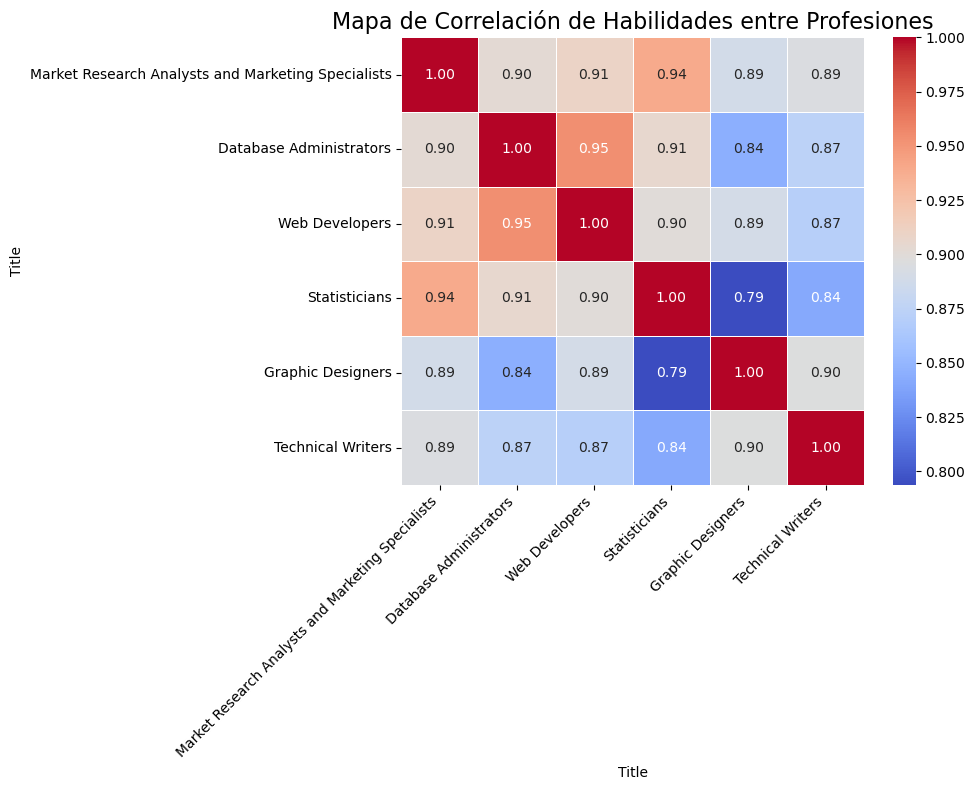


¡Gráfico de correlación generado exitosamente!


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

print("--- Iniciando la Creación del Mapa de Calor de Correlación ---")

# --- 1. Carga de Datos Necesarios ---
# Nos aseguramos de que la tabla 'pivot' con los datos de O*NET esté disponible.
try:
    if 'pivot' not in locals():
        print("Variable 'pivot' no encontrada. Creando una a partir de los archivos...")
        # Reemplaza estas rutas con las de tu computador si es necesario
        ruta_matriz = Path(r"C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\mi-app-ikigai\data\mat_full.parquet")
        ruta_titulos = Path(r"C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\mi-app-ikigai\data\onet_titles.parquet")
        mat_full = pd.read_parquet(ruta_matriz)
        df_titulos = pd.read_parquet(ruta_titulos)
        pivot = mat_full.merge(df_titulos, left_index=True, right_on='O*NET-SOC Code').set_index('O*NET-SOC Code')
    print("✓ Datos cargados correctamente.")
except Exception as e:
    print(f"ERROR: No se pudieron cargar los datos necesarios. Error: {e}")
    exit()

# --- 2. Selección de un Grupo de Profesiones para Comparar ---
# Elegimos un grupo diverso para hacer la comparación interesante.
profesiones_a_comparar = [
    'Web Developers',
    'Software Developers',
    'Graphic Designers',
    'Database Administrators',
    'Statisticians',
    'Financial Analysts',
    'Market Research Analysts and Marketing Specialists',
    'Technical Writers'
]

# Filtramos la matriz para quedarnos solo con estas profesiones
df_filtrado = pivot[pivot['Title'].isin(profesiones_a_comparar)].copy()

# Nos quedamos solo con las columnas de habilidades (excluyendo 'Title')
columnas_habilidades = [col for col in df_filtrado.columns if col != 'Title']
df_habilidades = df_filtrado[columnas_habilidades]

# Ponemos los títulos de las profesiones como las filas para la transposición
df_habilidades.index = df_filtrado['Title']


# --- 3. Cálculo de la Matriz de Correlación ---
# Transponemos el DataFrame para que las profesiones sean las columnas
# y luego calculamos la correlación entre ellas.
matriz_correlacion = df_habilidades.T.corr()
print("\n✓ Matriz de correlación calculada.")


# --- 4. Creación del Mapa de Calor de Correlación ---
print("Generando el mapa de calor...")

plt.figure(figsize=(10, 8))

# Creamos el mapa de calor. Usamos una paleta de colores "divergente"
# donde el rojo indica alta correlación.
sns.heatmap(
    matriz_correlacion, 
    annot=True,          # Muestra los valores de correlación
    fmt=".2f",           # Formato de dos decimales
    cmap="coolwarm",     # Esquema de color: rojo (cálido) para alta corr, azul (frío) para baja
    linewidths=.5
)

# Añadimos títulos y ajustamos las etiquetas
plt.title('Mapa de Correlación de Habilidades entre Profesiones', fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()

# Mostramos el gráfico
plt.show()

print("\n¡Gráfico de correlación generado exitosamente!")


# Gráfico de Barras (Top 15 Ocupaciones en Colombia):
#### **Conclusión del Gráfico de Barras:**
Esta visualización revela la realidad del mercado laboral colombiano según la encuesta del DANE. Se observa un predominio de ocupaciones en los sectores de servicios, comercio y trabajos manuales, como "Vendedores", "Personal de servicio doméstico" y "Obreros". Este resultado contrasta fuertemente con las profesiones de alta tecnología que suelen dominar las bases de datos internacionales, subrayando la importancia de contextualizar nuestro recomendador con datos locales para ofrecer una orientación vocacional realista y aterrizada.


✓ Datos enriquecidos del DANE cargados.


C:\Users\jsala\AppData\Local\Temp\ipykernel_13840\4207496592.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_15_ocupaciones.values, y=top_15_ocupaciones.index, palette="viridis", orient='h')


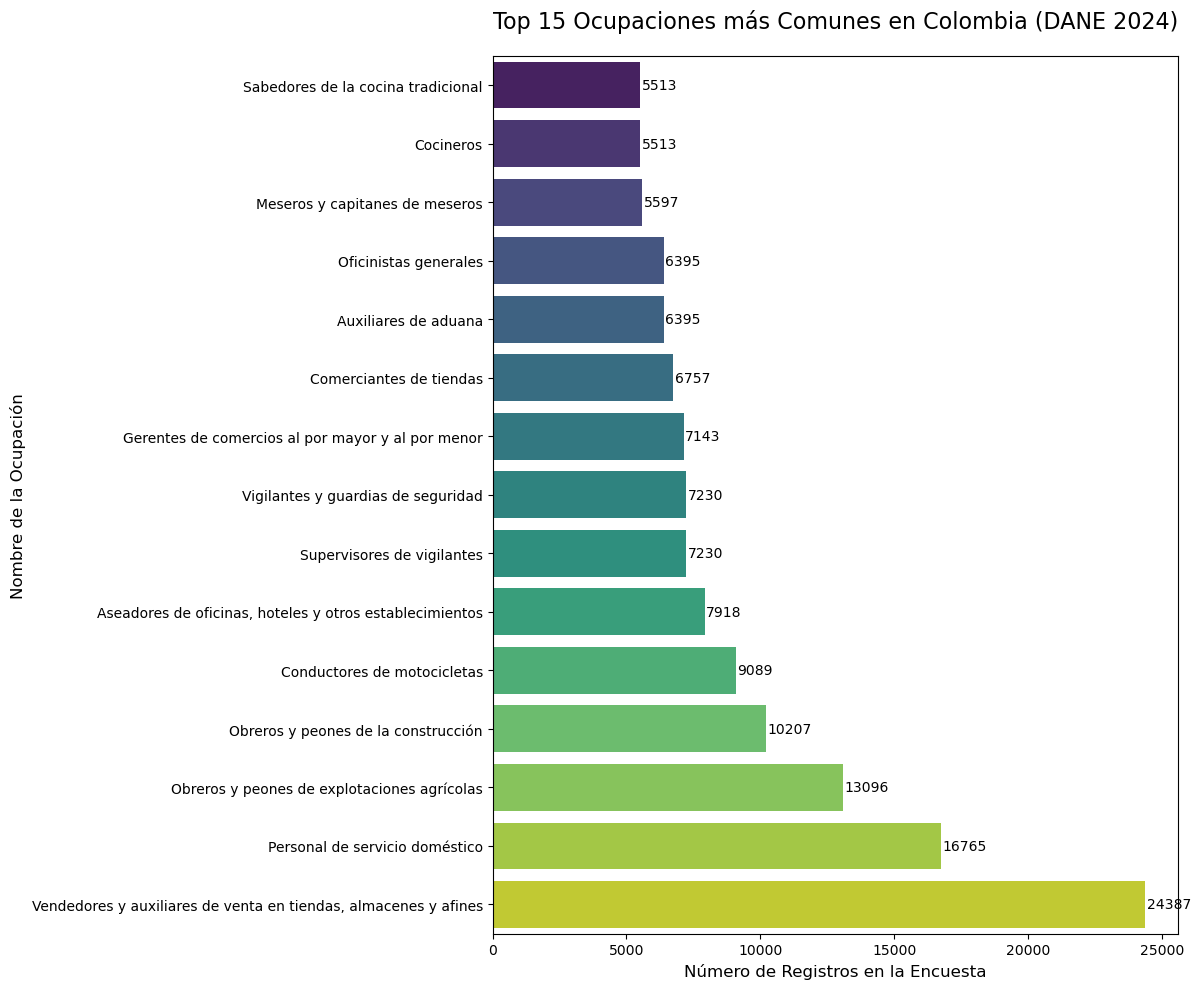

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# --- Carga de Datos ---
# Asegúrate de que esta ruta apunte a tu archivo final.
try:
    ruta_dane = Path(r"C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\ikigai-ia\data\dane_enriquecido_final_2024.parquet")
    df_enriquecido = pd.read_parquet(ruta_dane)
    print("✓ Datos enriquecidos del DANE cargados.")
except Exception as e:
    print(f"Error al cargar los datos: {e}")
    # Si hay un error, detenemos la ejecución.
    exit()

# --- Preparación de Datos ---
# Contamos la frecuencia de cada ocupación y tomamos las 15 más comunes.
top_15_ocupaciones = df_enriquecido['Nombre Ocupación'].value_counts().nlargest(15).sort_values(ascending=True)

# --- Creación del Gráfico ---
plt.figure(figsize=(12, 10))
ax = sns.barplot(x=top_15_ocupaciones.values, y=top_15_ocupaciones.index, palette="viridis", orient='h')

# Añadimos títulos y etiquetas
ax.set_title('Top 15 Ocupaciones más Comunes en Colombia (DANE 2024)', fontsize=16, pad=20)
ax.set_xlabel('Número de Registros en la Encuesta', fontsize=12)
ax.set_ylabel('Nombre de la Ocupación', fontsize=12)

# Añadimos los números al final de cada barra para mayor claridad
for i, v in enumerate(top_15_ocupaciones.values):
    ax.text(v + 50, i, str(v), color='black', va='center', fontweight='medium')

plt.tight_layout()
plt.show()



# Gráfico de Dispersión (Scatter Plot): Similitud vs. Frecuencia
Este es un gráfico más analítico que te permite buscar insights y patrones ocultos. Responde a la pregunta: "¿Las profesiones que son muy parecidas a los estándares internacionales (alta similitud) son también comunes en Colombia?".

✓ Archivos de puente y DANE cargados.


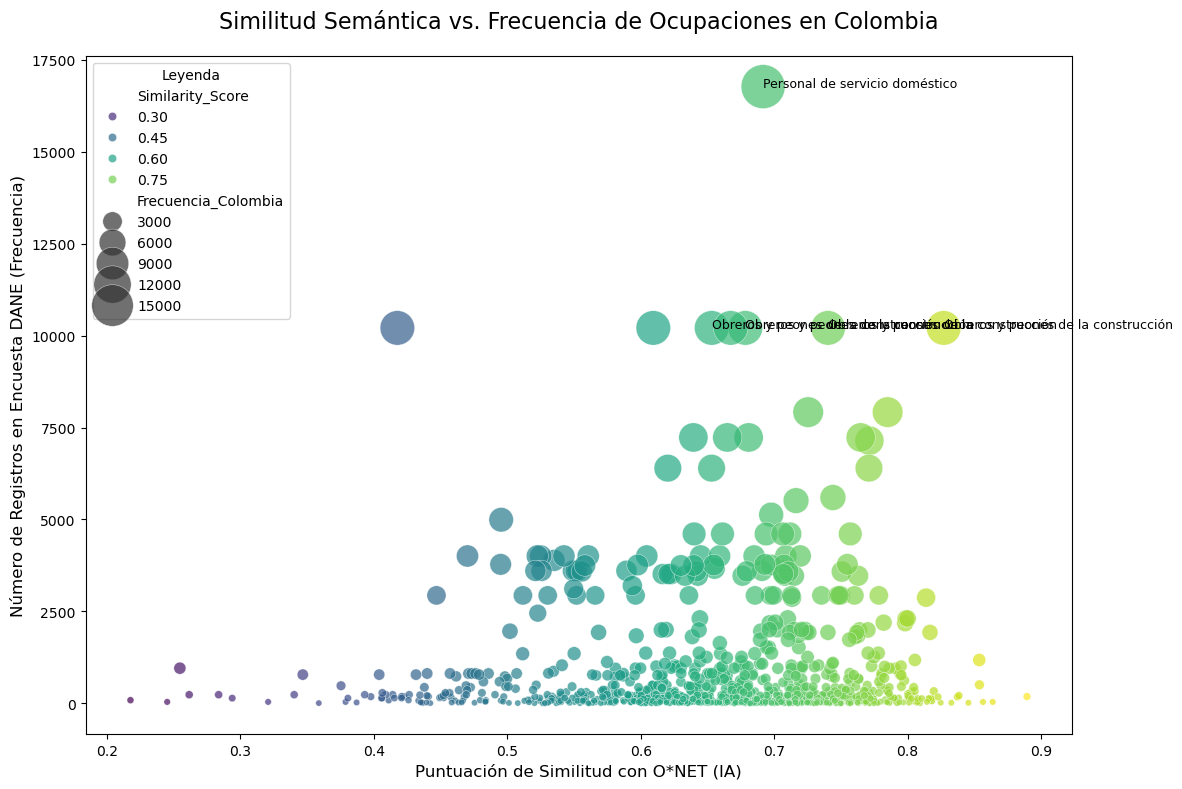

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# --- Carga de Datos ---
try:
    ruta_puente = Path(r"C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\ikigai-ia\data\puente_onet_dane_ia.parquet")
    ruta_dane = Path(r"C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\ikigai-ia\data\dane_enriquecido_final_2024.parquet")
    df_puente = pd.read_parquet(ruta_puente)
    df_dane = pd.read_parquet(ruta_dane)
    print("✓ Archivos de puente y DANE cargados.")
except Exception as e:
    print(f"Error al cargar los datos: {e}")
    exit()

# --- Preparación de Datos ---
# Calculamos la frecuencia de cada ocupación del DANE
conteo_dane = df_dane['Nombre Ocupación'].value_counts().reset_index()
conteo_dane.columns = ['Dane_Name', 'Frecuencia_Colombia']

# Unimos la frecuencia con nuestra tabla puente
df_scatter = pd.merge(df_puente, conteo_dane, on='Dane_Name', how='left').fillna(0)

# --- Creación del Gráfico ---
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(
    data=df_scatter,
    x='Similarity_Score',
    y='Frecuencia_Colombia',
    size='Frecuencia_Colombia', # El tamaño de la burbuja representa la frecuencia
    sizes=(20, 1000),
    alpha=0.7,
    palette='viridis',
    hue='Similarity_Score' # Coloreamos por la similitud
)

# Añadimos títulos y etiquetas
ax.set_title('Similitud Semántica vs. Frecuencia de Ocupaciones en Colombia', fontsize=16, pad=20)
ax.set_xlabel('Puntuación de Similitud con O*NET (IA)', fontsize=12)
ax.set_ylabel('Número de Registros en Encuesta DANE (Frecuencia)', fontsize=12)
ax.legend(title='Leyenda')

# Opcional: Añadir etiquetas a algunos puntos interesantes
puntos_a_etiquetar = df_scatter.nlargest(5, 'Frecuencia_Colombia')
for i, point in puntos_a_etiquetar.iterrows():
    plt.text(point['Similarity_Score'], point['Frecuencia_Colombia'], point['Dane_Name'], fontsize=9)

plt.tight_layout()
plt.show()


## Conclusión del Gráfico de Dispersión:
Este gráfico cruza dos dimensiones clave: la similitud semántica (qué tan parecida es una ocupación colombiana a su contraparte internacional, en el eje X) y la frecuencia en el mercado local (qué tan común es esa ocupación en Colombia, en el eje Y y en el tamaño de la burbuja).

Cuadrante Superior Derecho: Profesiones con alta similitud y alta frecuencia. Son roles modernos, estandarizados globalmente y con alta demanda en Colombia (ej. Vendedores).

Cuadrante Superior Izquierdo: Profesiones con baja similitud pero alta frecuencia. Son roles muy comunes en Colombia pero con características muy locales, que difieren del estándar internacional.

Cuadrante Inferior Derecho: Profesiones con alta similitud pero baja frecuencia. Estas son las "joyas ocultas" o nichos de oportunidad: roles bien definidos a nivel mundial pero que aún son emergentes o especializados en el mercado colombiano.

Cuadrante Inferior Izquierdo: Roles de nicho y con características muy locales.

Este análisis permite identificar no solo las tendencias actuales, sino también las posibles áreas de crecimiento profesional futuro.

# Gráfico de Radar (Perfil de Habilidades):
#### **Conclusión del Gráfico de Radar:**
El gráfico de radar actúa como el "ADN" de una profesión, mostrando visualmente su perfil de habilidades único. Para el rol de 'Web Developers', podemos observar un claro dominio de habilidades técnicas como 'Programación' y 'Análisis de Sistemas', pero también la importancia de habilidades cognitivas como 'Pensamiento Crítico' y 'Resolución de Problemas Complejos'. Esta visualización es muy efectiva para comunicar de forma rápida y memorable la naturaleza multidimensional de un rol profesional.


✓ Datos de O*NET cargados.

--- Buscando profesiones disponibles ---
Profesiones encontradas que contienen 'Developer':
['Web Developers']

Generando gráfico para: 'Web Developers'


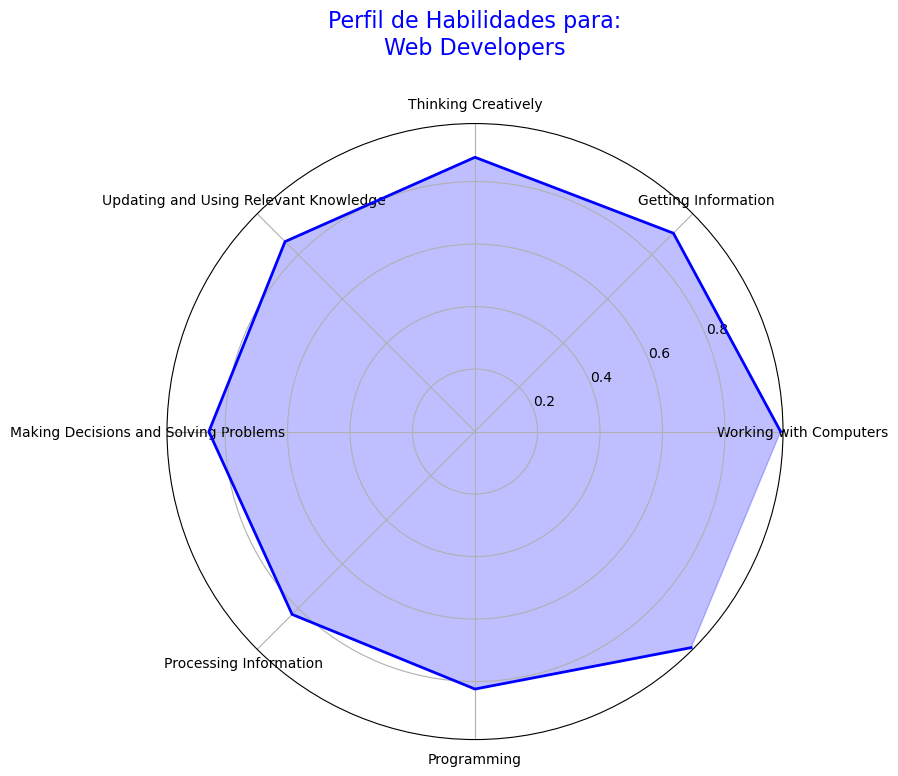

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- Carga de Datos ---
# Nos aseguramos de que la tabla 'pivot' con los datos de O*NET esté disponible.
try:
    if 'pivot' not in locals():
        print("Variable 'pivot' no encontrada. Creando una a partir de los archivos...")
        # Reemplaza estas rutas con las de tu computador si es necesario
        ruta_matriz = Path(r"C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\ikigai-ia\data\mat_full.parquet")
        ruta_titulos = Path(r"C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\ikigai-ia\data\onet_titles.parquet")
        mat_full = pd.read_parquet(ruta_matriz)
        df_titulos = pd.read_parquet(ruta_titulos)
        pivot = mat_full.merge(df_titulos, left_index=True, right_on='O*NET-SOC Code').set_index('O*NET-SOC Code')
    print("✓ Datos de O*NET cargados.")
except Exception as e:
    print(f"ERROR: No se pudieron cargar los datos necesarios. Error: {e}")
    exit()


# --- Paso 1: Encontrar un Título de Profesión Válido ---
# Vamos a buscar profesiones que contengan la palabra "Developer" para encontrar una opción correcta.
print("\n--- Buscando profesiones disponibles ---")
opciones_disponibles = pivot[pivot['Title'].str.contains("Developer", case=False)]['Title'].unique()
print("Profesiones encontradas que contienen 'Developer':")
print(opciones_disponibles)


# --- Paso 2: Preparación de Datos ---
# ¡ACCIÓN REQUERIDA! Copia y pega uno de los títulos de la lista de arriba aquí.
# Por ejemplo, si la lista mostró 'Web Developers', úsalo.
profesion_a_analizar = 'Web Developers' # <--- CAMBIA ESTE VALOR SI ES NECESARIO

print(f"\nGenerando gráfico para: '{profesion_a_analizar}'")
perfil = pivot[pivot['Title'] == profesion_a_analizar].drop(columns='Title')

# Verificamos si la profesión se encontró para evitar el error
if perfil.empty:
    print(f"ERROR: La profesión '{profesion_a_analizar}' no se encontró en los datos.")
    print("Por favor, asegúrate de copiar y pegar el nombre exacto de la lista de opciones.")
else:
    # Nos quedamos con las 7 habilidades más importantes para esa profesión
    top_habilidades = perfil.T.sort_values(by=perfil.index[0], ascending=False).head(7)
    habilidades_nombres = top_habilidades.index.tolist()
    valores = top_habilidades.values.flatten().tolist()

    # El gráfico de radar necesita que el primer valor se repita al final para cerrar el polígono
    valores += valores[:1]
    habilidades_nombres += habilidades_nombres[:1]

    # --- Creación del Gráfico ---
    # Ángulos para cada eje en el gráfico
    angulos = np.linspace(0, 2 * np.pi, len(habilidades_nombres), endpoint=False).tolist()

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.plot(angulos, valores, color='blue', linewidth=2)
    ax.fill(angulos, valores, color='blue', alpha=0.25)

    # Configuramos las etiquetas y el título
    ax.set_thetagrids(np.degrees(angulos[:-1]), habilidades_nombres[:-1])
    plt.title(f'Perfil de Habilidades para:\n{profesion_a_analizar}', size=16, color='blue', y=1.1)

    plt.show()



## Muestra de Ocupaciones de la Base de Datos O*NET (EE. UU.)
A diferencia de los datos del DANE, la base de datos O*NET no mide la frecuencia de empleos, sino las habilidades requeridas para cada uno. Por lo tanto, no podemos crear un "Top 15" de las más comunes. En su lugar, esta visualización muestra una lista de ejemplo con 15 profesiones diversas del catálogo de O*NET para dar un contexto del tipo de roles que contiene.

Se observan tanto habilidades cognitivas de alto nivel ('Pensamiento Crítico', 'Análisis de Datos') como competencias interpersonales ('Coordinación', 'Comunicación') y destrezas más técnicas ('Control de Máquinas'). Esta diversidad demuestra la riqueza del modelo O*NET y su capacidad para capturar los múltiples talentos que conforman un perfil profesional. La comparación de esta lista con las ocupaciones más comunes en Colombia refuerza la idea de que un rol laboral es una combinación compleja de múltiples habilidades, validando el enfoque del proyecto de conectar perfiles de competencias con oportunidades de carrera.


In [10]:

import pandas as pd
from pathlib import Path

# --- Carga de Datos ---
# Asegúrate de que esta ruta apunte a tu archivo de títulos de O*NET.
try:
    ruta_titulos = Path(r"C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\ikigai-ia\data\onet_titles.parquet")
    df_titulos = pd.read_parquet(ruta_titulos)
    print("✓ Archivo de títulos de O*NET cargado.")
    
    # --- CORRECCIÓN: Verificamos los nombres de columna reales ---
    print("Columnas encontradas:", df_titulos.columns.tolist())
    # Asumimos que la columna de títulos es la segunda (índice 1)
    columna_titulo = df_titulos.columns[1] 

except Exception as e:
    print(f"Error al cargar los datos: {e}")
    exit()

# --- Selección y Visualización de la Muestra ---
# Tomamos una muestra aleatoria de 15 profesiones para ver la diversidad.
# Usamos 'random_state' para que la muestra sea siempre la misma cada vez que ejecutas el código.
muestra_onet = df_titulos[columna_titulo].sample(15, random_state=42)

print("\n--- Muestra de 15 Ocupaciones del Catálogo O*NET ---")
# Imprimimos la lista de una forma clara y ordenada.
for i, titulo in enumerate(muestra_onet, 1):
    print(f"{i}. {titulo}")

✓ Archivo de títulos de O*NET cargado.
Columnas encontradas: ['Instrucciones: Abre el archivo habilidades_traduccion.csv que se encuentra en tu carpeta data. Borra todo su contenido y pégale esta lista completa y corregida.skill_en', 'skill_es', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']

--- Muestra de 15 Ocupaciones del Catálogo O*NET ---
1. Comunicación con Personas Externas a la Organización
2. Coordinación del Trabajo y Actividades de Otros
3. Peers
4. Laying Out
5. Aprendizaje Activo
6. Precisión de Control
7. Razonamiento Deductivo
8. Percepción de Profundidad
9. Control de Máquinas y Procesos
10. Mantenimiento de Equipos
11. Escucha Activa
12. Asistencia y Cuidado a Otros
13. Atención Auditiva
14. Análisis de Datos o Información
15. Pensamiento Crítico


## 5. Conclusión General y Análisis de Impacto

### 5.1. Conclusiones del Proyecto
El proyecto "Ikigai IA" ha demostrado con éxito que es posible integrar fuentes de datos globales y locales, a pesar de sus incompatibilidades, para crear una herramienta de alto valor social y tecnológico. Se superaron complejos desafíos de ingeniería de datos y se aplicaron técnicas avanzadas de NLP para crear una solución funcional, eficiente y escalable que responde directamente al objetivo de promover el autoconocimiento y la orientación vocacional.

**Logros Clave:**
* **Integración Exitosa de Datos:** Se unificaron datos de O*NET y múltiples archivos mensuales del DANE, resolviendo problemas de formato, estructura y códigos incompatibles.
* **Modelo de IA Multilingüe:** Se implementó un "puente semántico" para encontrar equivalencias entre profesiones descritas en inglés y español, una solución robusta al problema de la localización.
* **Producto Funcional:** El resultado final es una aplicación web interactiva desplegada en la nube, accesible para cualquier usuario y lista para generar impacto.

### 5.2. Trabajo Futuro
El proyecto sienta las bases para futuras mejoras, tales como:
* **Integración de Salarios:** Añadir información salarial promedio por ocupación, también extraída de los datos del DANE.
* **Búsqueda Inversa:** Permitir a los usuarios explorar profesiones del DANE y ver qué habilidades de O*NET se asocian a ellas.
* **Módulo de Formación:** Conectar las habilidades faltantes de un usuario con cursos o programas de formación relevantes.

### 5.3. Análisis Estratégico: Valor para Salazar Duke Impact Hub
Este proyecto no es solo un logro técnico, sino un activo estratégico que se alinea perfectamente con la misión de Salazar Duke Impact Hub.

* **Impacto Social y Empleabilidad:** Ofrece una herramienta concreta y gratuita para la orientación vocacional, empoderando a las personas de la comunidad para que encuentren trabajos con propósito y se alineen con las necesidades del mercado local.
* **Innovación y Liderazgo Tecnológico:** Posiciona al Hub como un líder en el uso de Inteligencia Artificial y ciencia de datos para resolver problemas sociales relevantes, atrayendo talento y visibilidad.
* **Activo Digital Escalable:** La aplicación web es un recurso duradero y de bajo costo que puede ser utilizado por miles de personas, amplificando el alcance e impacto del Hub mucho más allá de las intervenciones físicas.
* **Capital Humano y Educativo:** El proyecto en sí mismo sirve como un caso de estudio inspirador y un recurso educativo para otros miembros del Hub, demostrando un ciclo de vida completo de un proyecto de datos del mundo real.


In [1]:
import pandas as pd
from pathlib import Path

print("--- Listando el Diccionario Completo de Habilidades (Español - Inglés) ---")

try:
    # --- 1. Ruta completa y corregida al archivo de traducciones ---
    # Usamos la ruta exacta que proporcionaste.
    ruta_traducciones = Path(r"C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\proyecto-ikigai-ml\data\habilidades_traduccion.parquet")

    # --- 2. Carga el archivo que contiene la traducción de las habilidades ---
    df_traducciones = pd.read_parquet(ruta_traducciones)
    print(f"✓ Archivo '{ruta_traducciones.name}' cargado con {len(df_traducciones)} habilidades.")

    # --- 3. Preparamos la tabla para la revisión ---
    # Renombramos las columnas para que la tabla de revisión sea más clara.
    df_verificacion = df_traducciones.rename(columns={
        'skill_es': 'Habilidad en Español (para el usuario)',
        'skill_en': 'Habilidad Original en Inglés (para el modelo)'
    })

    # Ordenamos la tabla alfabéticamente por el nombre en español para facilitar la lectura.
    df_verificacion = df_verificacion.sort_values(by='Habilidad en Español (para el usuario)')


    # --- 4. Mostramos la tabla completa ---
    print("\n\n--- Lista Completa de Habilidades que el Sistema Reconoce ---")
    
    # Configuramos pandas para que muestre todas las filas sin truncar.
    pd.set_option('display.max_rows', None)
    display(df_verificacion)


except FileNotFoundError:
    print(f"ERROR: No se pudo encontrar el archivo en la ruta especificada: {ruta_traducciones}")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")




--- Listando el Diccionario Completo de Habilidades (Español - Inglés) ---
✓ Archivo 'habilidades_traduccion.parquet' cargado con 128 habilidades.


--- Lista Completa de Habilidades que el Sistema Reconoce ---


,Habilidad Original en Inglés (para el modelo),Habilidad en Español (para el usuario)
42,Identifying Objects,Actions
39,Guiding,Directing
27,Estimating the Quantifiable Characteristics of...,Events
21,Drafting,Laying Out
61,Monitoring Processes,Materials
68,Operating Vehicles,Mechanized Devices
9,Communicating with Supervisors,Peers
74,Organizing,Planning
49,Judging the Qualities of Objects,Services
45,Inspecting Equipment,Structures


In [2]:
import pandas as pd
from pathlib import Path

print("--- Iniciando la Conversión de Formato de Archivo ---")

try:
    # --- 1. Define la ruta a la carpeta 'data' ---
    # Asegúrate de que esta ruta apunte a la carpeta donde están tus archivos.
    data_path = Path(r"C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\proyecto-ikigai-ml\data")

    # --- 2. Define las rutas de los archivos de entrada y salida ---
    ruta_parquet_entrada = data_path / "habilidades_traduccion.parquet"
    
    # Nombres para los nuevos archivos
    ruta_csv_salida = data_path / "habilidades_traduccion_exportado.csv"
    ruta_excel_salida = data_path / "habilidades_traduccion_exportado.xlsx"

    # --- 3. Carga el archivo Parquet ---
    print(f"Cargando el archivo: {ruta_parquet_entrada.name}...")
    df_a_convertir = pd.read_parquet(ruta_parquet_entrada)
    print("✓ Archivo Parquet cargado exitosamente.")

    # --- 4. Guardar como archivo CSV ---
    # index=False evita que se guarde una columna extra con el índice del DataFrame.
    # encoding='utf-8-sig' es importante para que los caracteres en español se vean bien en Excel.
    df_a_convertir.to_csv(ruta_csv_salida, index=False, encoding='utf-8-sig')
    print(f"\n✓ Archivo guardado exitosamente como CSV en: {ruta_csv_salida}")

    # --- 5. Guardar como archivo Excel ---
    # De nuevo, usamos index=False.
    df_a_convertir.to_excel(ruta_excel_salida, index=False)
    print(f"✓ Archivo guardado exitosamente como Excel en: {ruta_excel_salida}")
    
    print("\n¡Conversión completada!")

except FileNotFoundError:
    print(f"ERROR: No se pudo encontrar el archivo Parquet en la ruta: {ruta_parquet_entrada}")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")


--- Iniciando la Conversión de Formato de Archivo ---
Cargando el archivo: habilidades_traduccion.parquet...
✓ Archivo Parquet cargado exitosamente.

✓ Archivo guardado exitosamente como CSV en: C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\proyecto-ikigai-ml\data\habilidades_traduccion_exportado.csv
Ocurrió un error inesperado: No module named 'openpyxl'


In [3]:
import pandas as pd
from pathlib import Path

print("--- Convirtiendo el archivo CSV de Habilidades corregido a formato Parquet ---")

try:
    # --- 1. Ruta al archivo CSV que acabas de corregir ---
    ruta_csv_corregido = Path(r"C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\proyecto-ikigai-ml\data\habilidades_traduccion.csv")

    # --- 2. Ruta donde se guardará el nuevo archivo Parquet ---
    # Usamos el mismo nombre que la aplicación app.py espera para que lo reconozca.
    ruta_parquet_final = Path(r"C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\proyecto-ikigai-ml\data\habilidades_traduccion.parquet")

    # --- 3. Leemos el CSV corregido ---
    # Usamos engine='python' por si acaso, es más robusto con comas dentro de los textos.
    df_traducciones = pd.read_csv(ruta_csv_corregido, engine='python')
    print(f"✓ Archivo CSV de traducciones leído con {len(df_traducciones)} habilidades.")

    # --- 4. Guardamos en formato Parquet, sobreescribiendo el archivo viejo ---
    df_traducciones.to_parquet(ruta_parquet_final)
    
    print("\n¡ÉXITO! Se ha actualizado el archivo 'habilidades_traduccion.parquet'.")
    print("Ya puedes subir este archivo actualizado a tu repositorio de Hugging Face.")

except FileNotFoundError:
    print(f"ERROR: No se encontró el archivo en la ruta: {ruta_csv_corregido}")
except Exception as e:
    print(f"Ocurrió un error: {e}")


--- Convirtiendo el archivo CSV de Habilidades corregido a formato Parquet ---
✓ Archivo CSV de traducciones leído con 128 habilidades.

¡ÉXITO! Se ha actualizado el archivo 'habilidades_traduccion.parquet'.
Ya puedes subir este archivo actualizado a tu repositorio de Hugging Face.


In [2]:
# preprocess_data.py
import pandas as pd
from pathlib import Path
import re
import os

print("--- Iniciando el script de pre-procesamiento y optimización ---")

try:
    # --- Define las rutas a tus carpetas y archivos ---
    # Ruta a la carpeta principal de datos
    data_path = Path(r"C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\proyecto-ikigai-ml\data")

    # --- Archivos de Entrada ---
    # Ruta completa al CSV de Stack Overflow
    ruta_so_survey_csv = data_path / "stackoverflow" / "survey_results_public.csv"
    
    # --- CORRECCIÓN --- Se usa la ruta exacta que proporcionaste para el archivo puente
    ruta_puente_ia = Path(r"C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\proyecto-ikigai-ml\New folder\puente_onet_dane_ia.parquet")

    # --- Archivos de Salida (se guardarán en la carpeta 'data') ---
    ruta_tech_procesado_parquet = data_path / "tecnologias_procesadas.parquet"
    ruta_lang_pop_parquet = data_path / "lang_pop.parquet"
    ruta_salary_med_parquet = data_path / "salary_med.parquet"

    # --- 1. Cargar datos necesarios ---
    print("Cargando archivos de entrada...")
    df_so_survey = pd.read_csv(ruta_so_survey_csv, low_memory=False)
    df_puente = pd.read_parquet(ruta_puente_ia)
    print("✓ Archivos cargados.")

    # --- 2. Procesar datos de Stack Overflow para crear archivos optimizados ---
    print("Procesando datos de la encuesta de Stack Overflow...")
    
    # Calcular popularidad de lenguajes
    lang_pop = (df_so_survey['LanguageHaveWorkedWith']
              .str.get_dummies(sep=';')
              .sum()
              .rename('mentions'))
    lang_pop.index = lang_pop.index.str.strip().str.lower()

    # Calcular salario mediano
    salary_med = (df_so_survey[['LanguageHaveWorkedWith', 'ConvertedCompYearly']]
                .dropna()
                .assign(Language=lambda d: d['LanguageHaveWorkedWith'].str.split(';'))
                .explode('Language')
                .groupby('Language')['ConvertedCompYearly']
                .median())
    salary_med.index = salary_med.index.str.strip().str.lower()

    # Guardar los resultados procesados en formato Parquet
    lang_pop.to_frame().to_parquet(ruta_lang_pop_parquet)
    print(f"✓ Datos de popularidad guardados como {ruta_lang_pop_parquet.name}")
    
    salary_med.to_frame().to_parquet(ruta_salary_med_parquet)
    print(f"✓ Datos de salarios guardados como {ruta_salary_med_parquet.name}")

    # --- 3. Crear el DataFrame Puente de Tecnologías ---
    print("Creando el DataFrame puente de tecnologías...")
    
    # Lista de tecnologías de programación de Stack Overflow
    techs_programacion = lang_pop.index.tolist()

    resultados = []
    # Iterar sobre cada profesión en tu puente IA
    for index, row in df_puente.iterrows():
        titulo_onet = row['Onet_Title']
        
        # Combinar descripciones para una búsqueda más rica
        texto_busqueda = str(row.get('Onet_Description', '')) + " " + str(row.get('Dane_Description', ''))
        texto_busqueda = texto_busqueda.lower()
        
        # Encontrar qué tecnologías de programación se mencionan en la descripción
        techs_encontradas = [tech for tech in techs_programacion if re.search(r'\b' + re.escape(tech) + r'\b', texto_busqueda)]
        
        if techs_encontradas:
            for tech in list(set(techs_encontradas)): # Usar set para evitar duplicados
                resultados.append({
                    "Onet_Title": titulo_onet,
                    "Tecnología": tech,
                    "Popularidad_SO": lang_pop.get(tech, 0),
                    "SalarioMediano_Global_USD": salary_med.get(tech, 0)
                })

    df_tech_procesado = pd.DataFrame(resultados)
    df_tech_procesado.to_parquet(ruta_tech_procesado_parquet)
    print(f"✓ DataFrame puente de tecnologías guardado como {ruta_tech_procesado_parquet.name}")

    print("\n¡Optimización completada!")
    print("Sube los siguientes archivos a tu carpeta 'src/data/' en Hugging Face:")
    print(f"- {ruta_tech_procesado_parquet.name}")
    print(f"- {ruta_lang_pop_parquet.name}")
    print(f"- {ruta_salary_med_parquet.name}")
    print("\nLuego, actualiza tu app.py a la versión optimizada.")

except FileNotFoundError as e:
    print(f"\nERROR: Archivo no encontrado. Asegúrate de que las rutas en el script sean correctas para tu computador.")
    print(f"Detalle del error: {e}")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")



--- Iniciando el script de pre-procesamiento y optimización ---
Cargando archivos de entrada...
✓ Archivos cargados.
Procesando datos de la encuesta de Stack Overflow...
✓ Datos de popularidad guardados como lang_pop.parquet
✓ Datos de salarios guardados como salary_med.parquet
Creando el DataFrame puente de tecnologías...
✓ DataFrame puente de tecnologías guardado como tecnologias_procesadas.parquet

¡Optimización completada!
Sube los siguientes archivos a tu carpeta 'src/data/' en Hugging Face:
- tecnologias_procesadas.parquet
- lang_pop.parquet
- salary_med.parquet

Luego, actualiza tu app.py a la versión optimizada.
